# Homework 2 CSCI 4364/6364 Machine Learning

##**Adventures in Linear Regression**
v.20230912a

**Due Date: 9/26/2023, 23:59 ET**

---

**Purpose:**
This homework will familiarize you with linear regression using the [Prostate Cancer dataset](https://hastie.su.domains/ElemStatLearn/data.html). First, you’ll work with the least squares. Then you’ll investigate regression using L2 (Ridge) and L1 (Lasso) regularization. Finally, you will implement an iterative version of L2 Regularization using gradient descent.

**Note**: Besides part 3, you should implement your solution with the fundamental equations we discussed in class and in Hastie, chapter 3. *Only in part 3, you should use Scikit-Learn*.



---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

**Important:** Please submit your assignment with outputs, by navigating to Edit >> Notebook Settings and ensuring *Omit code cell output when saving this notebook* is **NOT** selected.

---

**Grading on the notebook:**

Parts 1 - 4 of this notebook are worth 5% of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Extra Credit!** Besides being a great learning experience about convex optimization, part 5 is **optional**, but worth up to 2% of the semester grade.

**Coding Standards:**
Throughout this course, we will use Google’s Python Style Guide (https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Toghrul Tahirov

**GW ID:** G47609664

In [1]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import pandas as pd # Pandas dataframe libaries
import numpy as np # Numpy numerical computation library
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn import metrics # Used to compute metrics, such as the Area Under the Curve (AUC)
import matplotlib.pyplot as plt # Plotting library.
from typing import Union, List, Tuple, Mapping # Common types for Python type definitions


# Data Preperation & Feature Analysis (Prostate Cancer)



In [2]:
#@title Load the Prostate Cancer dataset
_SEED = 1223
random_state = np.random.RandomState(_SEED)
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/prostate.csv')
# Randomize the rows
df = df.sample(frac =  1, random_state=random_state)

In [3]:
#@title Split into training and test set
# Following Hastie p.50, we create a training set of 67
split_index = 67
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

In [4]:
# let's look at the shape of the training and test sets
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

Training set shape: (67, 9)
Test set shape: (30, 9)


Since we have already loaded the data and split it into training and test sets, we can now begin to explore the data which is an indispensible part of every ML project. We will start by checking out some basic statistics of the data, such as the mean, standard deviation, and quartiles. We will also plot the data to see if we can find any trends.

In [5]:
df_train.describe()

lcavol    lweight        age       lbph        svi        lcp  \
count  67.000000  67.000000  67.000000  67.000000  67.000000  67.000000   
mean    1.281568   3.631081  63.492537   0.043592   0.208955  -0.305764   
std     1.225340   0.423991   7.558606   1.446755   0.409631   1.394618   
min    -1.347074   2.691243  41.000000  -1.386294   0.000000  -1.386294   
25%     0.460579   3.394507  60.000000  -1.386294   0.000000  -1.386294   
50%     1.308333   3.598681  64.000000  -0.051293   0.000000  -1.386294   
75%     2.293414   3.843729  68.000000   1.448936   0.000000   0.810930   
max     3.821004   4.780383  78.000000   2.326302   1.000000   2.583998   

         gleason      pgg45       lpsa  
count  67.000000  67.000000  67.000000  
mean    6.746269  24.253731   2.415862  
std     0.745558  28.528212   1.255188  
min     6.000000   0.000000  -0.430783  
25%     6.000000   0.000000   1.578766  
50%     7.000000  10.000000   2.591516  
75%     7.000000  45.000000   3.306402  
max     9.000000  95.000000   5.477509

Great, we can see some statistics of the different features we have. But, this will not tell us anything until we have an idea of what each feature represents. So let's take a look at the feature descriptions:

1. **lcavol**: Logarithm of cancer volume - Represents the natural logarithm of the volume of the cancer. A higher value indicates a larger tumor volume.

2. **lweight**: Logarithm of prostate weight - Represents the natural logarithm of the weight of the prostate. This feature helps in understanding the size of the prostate.

3. **age**: Age of the patient - Represents the age of the patient at the time of diagnosis. Age is a significant factor in prostate cancer risk.

4. **lbph**: Logarithm of benign prostatic hyperplasia amount - Represents the natural logarithm of the amount of benign prostatic hyperplasia (BPH). BPH is a noncancerous enlargement of the prostate gland.

5. **svi**: Seminal vesicle invasion - A binary feature indicating the presence (1) or absence (0) of seminal vesicle invasion. Seminal vesicle invasion is a sign of advanced disease.

6. **lcp**: Logarithm of capsular penetration - Represents the natural logarithm of the extent of capsular penetration. Capsular penetration indicates that cancer has grown through the prostate capsule.

7. **gleason**: Gleason score - A grading system used to determine the aggressiveness of prostate cancer. The score ranges from 2 to 10, with higher scores indicating more aggressive cancer.

8. **pgg45**: Percentage of Gleason scores 4 or 5 - Represents the percentage of the tumor that is composed of Gleason patterns 4 or 5. Higher percentages indicate more aggressive tumors.

9. **lpsa**: Logarithm of prostate-specific antigen - Represents the natural logarithm of the level of prostate-specific antigen (PSA) in the blood. Elevated PSA levels can indicate the presence of prostate cancer.


In this task, our goal is to develop several Regression Models from scratch and test the predictive capabilities of each model. The prediction target is the logarithm of the prostate-specific antigen (lpsa) which is a measure of the severity of the prostate cancer. We will use the mean squared error (MSE) as our loss function. The MSE is defined as:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 $$

Where:
- $( n )$ is the total number of observations in the dataset.
- $( Y_i )$ is the actual value of the observation.
- $(\hat{Y}_i)$ is the predicted value of the observation.


Now that we know what the task is and we have an idea of what the features represent, we can start analyzing the data. From the above description of the data, we can see that the features vary greatly in terms of their domain of values. For example, the feature **age** has a range of 41 to 79, while the feature **pgg45** has a range of 0 to 95. Also, some features exhibit high varience. Coupled with the fact that the amount of data we have is relatively small, this can cause problems for our models. This should certainly be kept in mind when we are developing the models and checking for correlations.

Let's confirm the distributions of the features using boxplots. Boxplots are a great way to visualize the distribution of the data. They show the median, quartiles, and outliers of the data. We will use the default quartile values for the boxplots which are 25% and 75%.

<AxesSubplot:>

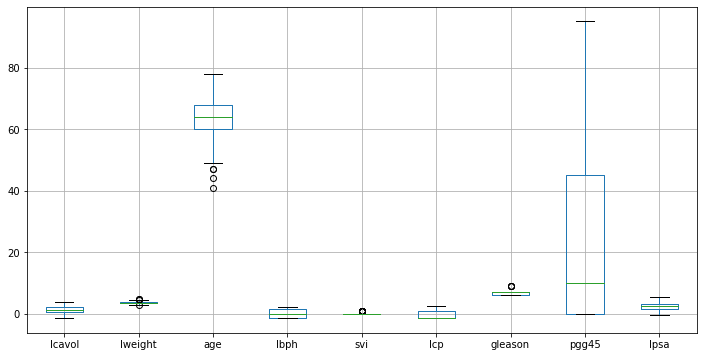

In [6]:
# Display the boxplot of the training set
df_train.boxplot(figsize=(12, 6))

The difference in value scales is quite apparent. We will test the models with the data as is, and then we will normalize the data and test the models again to see if there is any improvement. It is also importatn to check for correlations between the features. If two features are highly correlated, then we can remove one of them from the dataset. This will reduce the dimensionality of the data and will help the models perform better. We will use the Pearson correlation coefficient for this task.

<AxesSubplot:>

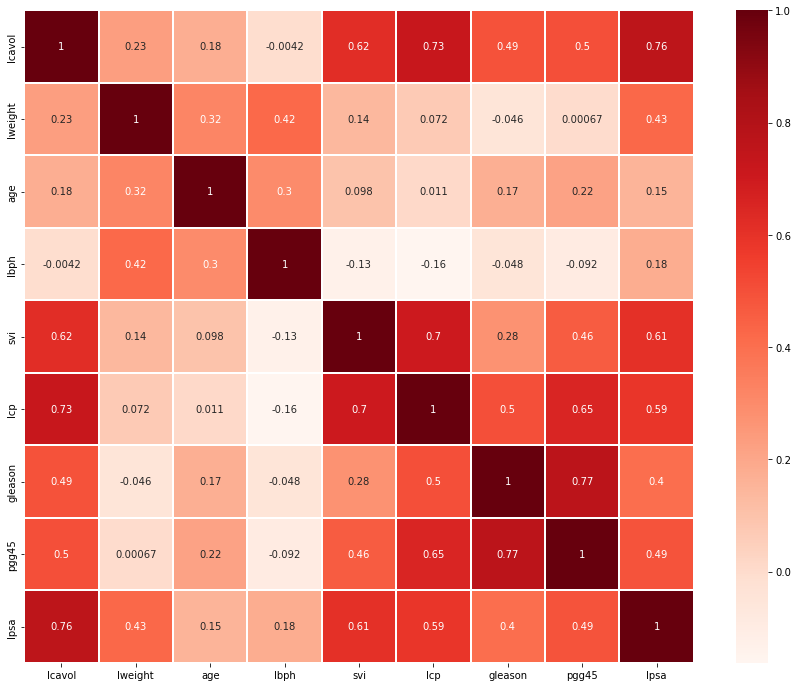

In [7]:
# Compute the Pearson correlation matrix
corr = df_train.corr()
# Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, annot=True, cmap='Reds', 
            linewidths=0.2, ax=ax)

In [8]:
# Sorting the correlation matrix by the correlation to the lpsa column
corr_lpsa = corr['lpsa'].sort_values(ascending=False)
# Print the correlations to the lpsa column
print(f"Correlations to the lpsa column:\n{corr_lpsa}")

Correlations to the lpsa column:
lpsa       1.000000
lcavol     0.762191
svi        0.605025
lcp        0.590916
pgg45      0.491045
lweight    0.427177
gleason    0.400986
lbph       0.182307
age        0.152466
Name: lpsa, dtype: float64


There are some features that are highly correlated with the target variable, especially **lcavol** and **svi**. We'll see if our models judge them to be as important
We can also spot some features that are relatively strongly correlated with each other. The correlation levels are not so high that we should simply discard some of the variables, so we'll have to test and see

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

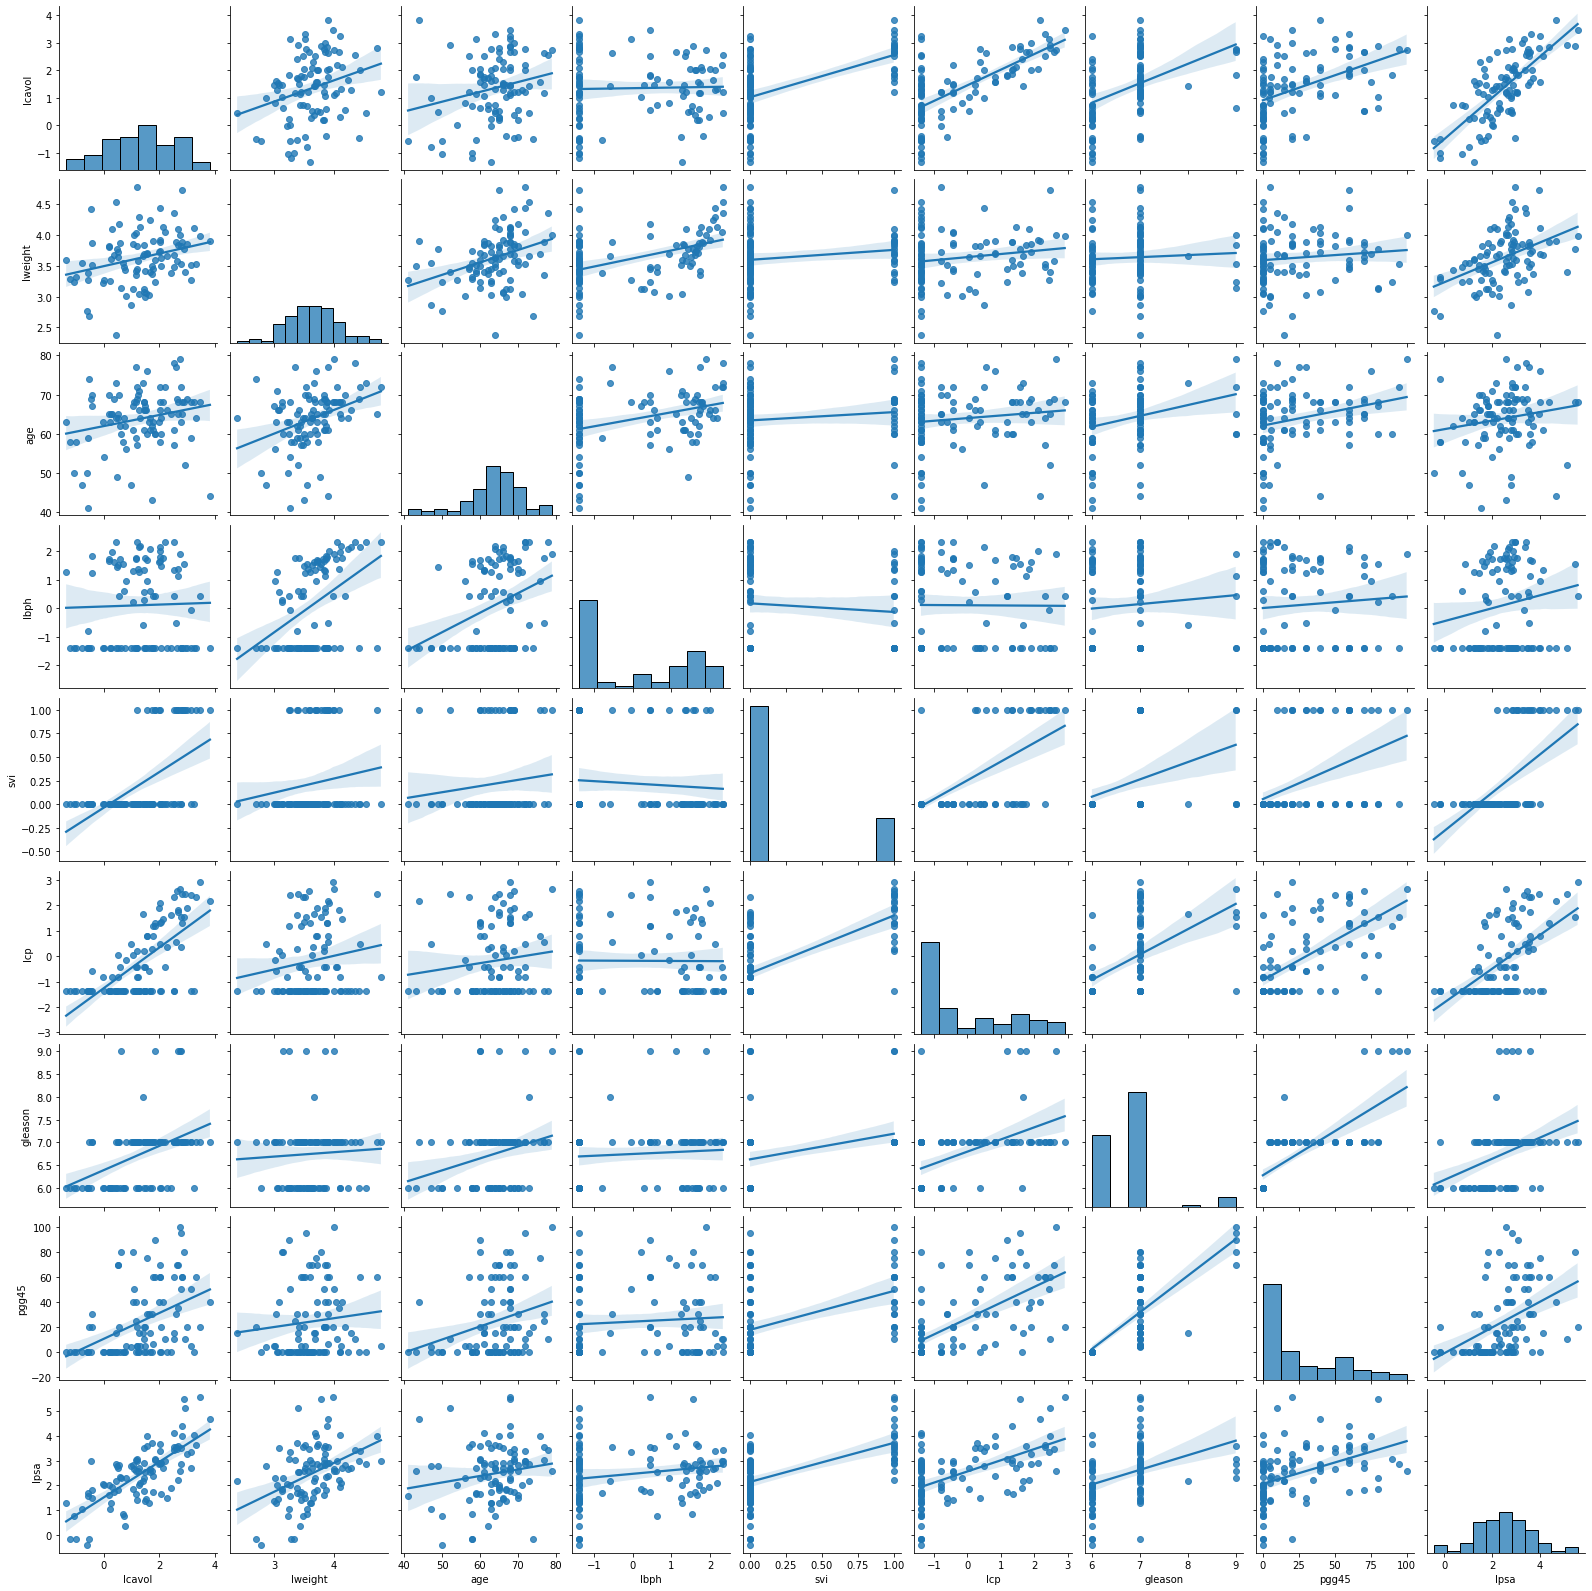

In [9]:
#@title Display pair plots
sns.pairplot(df, kind="reg")
plt.show()

In [10]:
#@title Split the labels and convert to numpy arrays
y_train = df_train['lpsa'].to_numpy()
X_train = df_train.copy().drop(columns = ['lpsa']).to_numpy()
y_test = df_test['lpsa'].to_numpy()
X_test = df_test.copy().drop(columns = ['lpsa']).to_numpy()

In [11]:
class BaseLearningAlgorithm(ABC):
    """Base class for a Supervised Learning Algorithm."""

    @abstractmethod
    def train(self, X_train: np.array, y_train: np.array) -> None:
        """Trains a model from labels y and examples X."""

    @abstractmethod
    def predict(self, X_test: np.array) -> np.array:
        """Predicts on an unlabeled sample, X."""

    @abstractmethod
    def initialize_with_params(self, params: Mapping[str, Union[int, float]]) -> None:
        """Initializes the algorithm with the given parameters."""

    @property
    @abstractmethod
    def name(self) -> str:
        """Returns the name of the algorithm."""
        
    def initialize_with_params(self, weights: np.array) -> None:
        """Initializes the algorithm with the given parameters."""
        self.weights = weights

In [12]:
def regression_report(y_test: np.ndarray, y_pred: np.ndarray, plot_results: bool=True) -> pd.DataFrame:
    """Reports and returns the regression metrics.
    Params:
      X_test: np.ndarray, shape (n_samples, n_features)
      y_test: np.ndarray, shape (n_samples,)
    Returns:
      results_df: pd.DataFrame, shape (1, 3)"""
    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2: {r2}")
    
    if plot_results:
      fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))
      # Plot the predictions vs. the true values
      ax1.scatter(y_test, y_pred, color='blue', alpha=0.5)
      # Plot the line y = x
      ax1.plot(y_test, y_test, 'r--' )
      ax1.set_xlabel("True values")
      ax1.set_ylabel("Predictions")
      ax1.set_title("Predictions vs. true values")
      
      # Plot the distribution of the residuals vs the distribution of the predictions
      sns.histplot(y_test - y_pred, bins=50, color='blue', ax=ax2)
      ax2.legend()
      ax2.set_title("Distribution of the Residuals")
      
    results_df = pd.DataFrame({'MSE': [mse], 'RMSE': [rmse], 'R^2': [r2]})
    return results_df

In [13]:
class Scaler(ABC):
    """Base class for a Scaler."""
    
    @abstractmethod
    def fit(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> None:
        """Fits the scaler to the data."""
    
    @abstractmethod
    def transform(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> np.array:
        """Transforms the data."""
        
    @abstractmethod
    def inverse_transform(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> np.array:
        """Inverse transforms the data."""

In [87]:
class StandardScaler(Scaler):
    """Apply standard scaling to the data."""
    
    def __init__(self):
        self.mean_X = None
        self.std_X = None
        
    def fit(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> None:
        """Fits the scaler to the data.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns: None
        """
        self.mean_X = np.mean(X, axis=0)
        self.std_X = np.std(X, axis=0)
        
        if y is not None:
            self.mean_y = np.mean(y)
            self.std_y = np.std(y)
        
    def transform(self, 
            X: Union[np.array, None] = None,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        
        X_scaled = None 
        y_scaled = None
        
        if X is not None:
            X_scaled = (X - self.mean_X) / self.std_X
        
        if y is not None:
            y_scaled = (y - self.mean_y) / self.std_y
        
        if X_scaled is not None and y_scaled is not None:
            return X_scaled, y_scaled
        elif X_scaled is not None:
            return X_scaled
        elif y_scaled is not None:
            return y_scaled        
    
    def inverse_transform(self, 
            X: Union[np.array, None] = None,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Inverse transforms the data using the fitted scaler parameters.
        Params:
        - (optional) X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = None 
        y_scaled = None
        
        if X is not None:
            X_scaled = X * self.std_X + self.mean_X
            
        if y is not None:
            y_scaled = y * self.std_y + self.mean_y
            
        if X_scaled is not None and y_scaled is not None:
            return X_scaled, y_scaled
        elif X_scaled is not None:
            return X_scaled
        elif y_scaled is not None:
            return y_scaled
        else:
            return None
        
        

In [15]:
class MinMaxScaler(Scaler):
    def __init__(self):
        self.min_X = None
        self.max_X = None
        
    def fit(self,
            X: np.array,
            y: Union[np.array, None] = None
            ) -> None:
        """Fits the scaler to the data.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns: None
        """
        self.min_X = np.min(X, axis=0)
        self.max_X = np.max(X, axis=0)
        
        if y is not None:
            self.min_y = np.min(y)
            self.max_y = np.max(y)
            
    def transform(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = (X - self.min_X) / (self.max_X - self.min_X)
        
        if y is not None:
            y_scaled = (y - self.min_y) / (self.max_y - self.min_y)
            return X_scaled, y_scaled
        
        return X_scaled
    
    def inverse_transform(self,
            X: Union[np.array, None] = None,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Inverse transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = None 
        y_scaled = None
        
        if X is not None:
            X_scaled = X * (self.max_X - self.min_X) + self.min_X
            
        if y is not None:
            y_scaled = y * (self.max_y - self.min_y) + self.min_y
            
        if X_scaled is not None and y_scaled is not None:
            return X_scaled, y_scaled
        elif X_scaled is not None:
            return X_scaled
        elif y_scaled is not None:
            return y_scaled
        else:
            return None            
        

In [16]:
class LogTransformScaler(Scaler):
    def __init__(self):
        self.min_X = None
        self.max_X = None

    def fit(self, X: np.array, y: Union[np.array, None] = None) -> None:
        """Fits the scaler to the data.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns: None
        """
        self.min_X = np.min(X, axis=0)

        if y is not None:
            self.min_y = np.min(y)

    def transform(
        self, X: np.array, y: Union[np.array, None] = None
    ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = np.log(X + np.abs(self.min_X) + 1)

        if y is not None:
            y_scaled = np.log(y + np.abs(self.min_y) + 1)
            return X_scaled, y_scaled

        return X_scaled

    def inverse_transform(
        self, X: Union[np.array, None] = None, y: Union[np.array, None] = None
    ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Inverse transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = None
        y_scaled = None

        if X is not None:
            X_scaled = np.exp(X) - np.abs(self.min_X) - 1

        if y is not None:
            y_scaled = np.exp(y) - np.abs(self.min_y) - 1

        if X_scaled is not None and y_scaled is not None:
            return X_scaled, y_scaled
        elif X_scaled is not None:
            return X_scaled
        elif y_scaled is not None:
            return y_scaled
        else:
            return None

In [17]:
# def standardize(X: np.array, 
#                 mean: Union[np.array, None] = None, 
#                 std: Union[np.array, None] = None 
#                 ) -> np.array:
#   """Standardizes the columns of the matrix X. If mean and std are not None,
#     then these values are used to standardize the matrix X. Otherwise, the
#     mean and std are computed from the matrix X.
#   """
  
#   if not mean or not std:
#     mean = np.mean(X, axis=0)
#     std = np.std(X, axis=0)
#   elif mean.shape != X.shape[1] or std.shape != X.shape[1]:
#     raise ValueError("The mean and std must have the same shape as the number of columns in X.")
#   elif not mean and std or mean and not std:
#     raise ValueError("The mean and std must be both None or both must be specified.")
  
#   return (X - mean) / std, mean, std

In [18]:
def plot_weights_vs_model_param(lr_results_df, model_param):
    """
    Plots the weights as a function of alpha for a given feature.

    Parameters:
    lr_results_df (pandas|.DataFrame): The dataframe containing the linear regression results.
    feature (str): The feature to be analyzed.

    Returns:
    None
    """
    features = [col for col in lr_results_df.columns if col.startswith("w_")]
    n_cols = 3
    n_rows = int(np.ceil(len(features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))
    
    min_mse = lr_results_df["mse"].min()
    min_mse_feature = lr_results_df[lr_results_df["mse"] == min_mse][model_param].values[0]

    for i, ax in enumerate(axes.flatten()):
        if i >= len(features):
            ax.axis("off")
            continue
        ax.plot(lr_results_df[model_param].values, lr_results_df[features[i]].values)
        # add a vertical line at the minimum MSE
        ax.axvline(
            min_mse_feature,
            color="red",
            linestyle="--",
        )
        # add text annotation for the minimum MSE with a black background and white text
        ax.text(
            min_mse_feature,
            lr_results_df[features[i]].min(),
            f"min MSE = {min_mse_feature:.5f} at {model_param} = {min_mse_feature:.5f}",
            bbox=dict(facecolor="black", alpha=0.7),
            color="white",
        )

        ax.set_xlabel(model_param)
        ax.set_ylabel(features[i])
        ax.set_title(f"{features[i]} as a function of {model_param}")

# 1. Linear Regression with Least Squares
Implement a class called `BasicLeastSquaresRegression` that extends `BaseLearningAlgorithm` with “vanilla” least squares regression described in Hastie 3.2. Compute the $\boldsymbol{\beta}$ coefficient vector and solve for $\hat{y} $ and compute the performance result as the mean squared error on the test set. Use only numpy for your solution.





In [19]:
class BasicLeastSquaresRegression(BaseLearningAlgorithm):
    """A basic least squares regression model.
    This model is not regularized.
    """

    def __init__(self):
        """Initializes the model."""

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.6
        self._weights = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights

    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Least Squares Regression"

Mean Squared Error: 0.5561806405313257
Root Mean Squared Error: 0.7457751943657859
R^2: 0.2773118726338625


c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


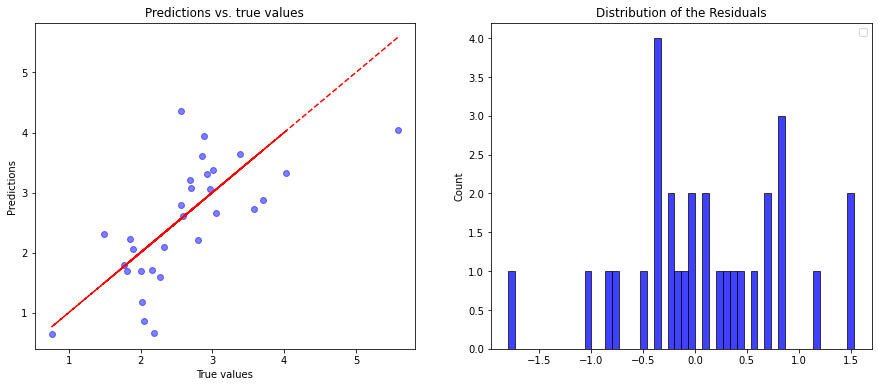

In [20]:
LSR = BasicLeastSquaresRegression()
LSR.train(X_train, y_train)
y_pred_lsr = LSR.predict(X_test)
reg_res_og = regression_report(y_test, y_pred_lsr)


Now, let's examine the importance of the features in the model. We will use the absolute value of the coefficients as a measure of importance. The higher the absolute value of the coefficient, the more important the feature is.

In [21]:
def display_feature_ranking(df_train: pd.DataFrame, weights: np.ndarray) -> None:
    """Displays the feature ranking."""
    sorted_features = np.argsort(weights)[::-1]

    fig, ax = plt.subplots(figsize=(12, 6))
    plot = sns.barplot(
        x=weights[sorted_features],
        y=df_train.columns[sorted_features],
        ax=ax,
        palette="plasma",
    )

    # Annotate the bars
    for p in plot.patches:
        ax.annotate(
            "%.4f" % p.get_width(),
            xy=(p.get_width(), p.get_y() + p.get_height() / 2),
            xytext=(5, 0),
            textcoords="offset points",
            ha="left",
            va="center",
        )

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


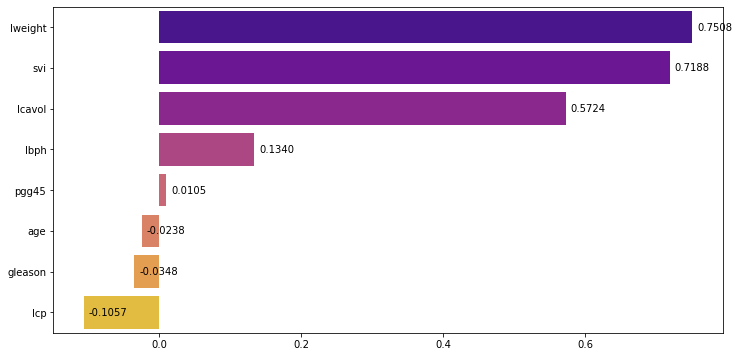

In [22]:
# Display the feature ranking
display_feature_ranking(df_train, LSR._weights[:-1])

We can see that the MSE loss is quite high and our R2 score is quite low. Model performance does not seem to be reliable at all. One of the nuances we spotted early on was the difference in value scales of the features. Let's see if normalizing the data will improve performance. We'll try standard, min-max, and log normalization.

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.5561806405313204
Root Mean Squared Error: 0.7457751943657823
R^2: 0.27731187263386925


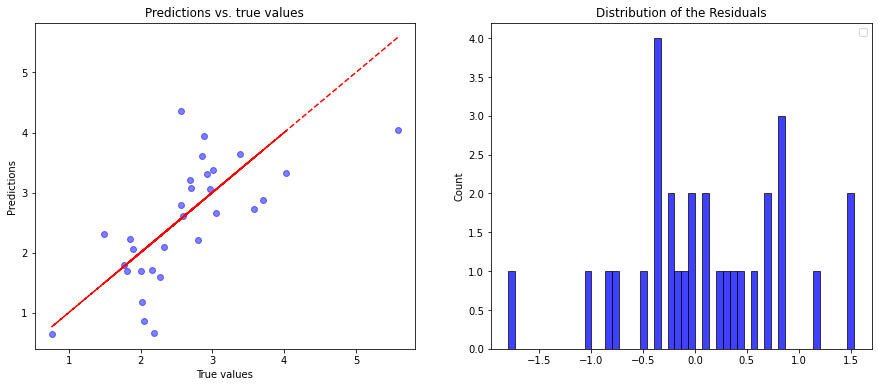

In [23]:
# Normalize the data using the StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_std, y_train_std = std_scaler.transform(X_train, y_train)
X_test_std = std_scaler.transform(X_test)

# Train the model on the standardized data
LSR_std = BasicLeastSquaresRegression()
LSR_std.train(X_train_std, y_train_std)
y_pred_lsr_std = LSR_std.predict(X_test_std)
y_pred_lsr_std = std_scaler.inverse_transform(y=y_pred_lsr_std)

reg_res_std = regression_report(y_test, y_pred_lsr_std)

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


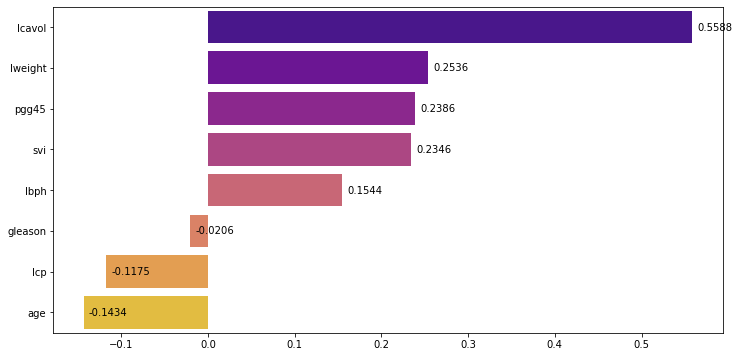

In [24]:
# Display the feature ranking
display_feature_ranking(df_train, LSR_std._weights[:-1])

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.556180640531318
Root Mean Squared Error: 0.7457751943657807
R^2: 0.27731187263387247


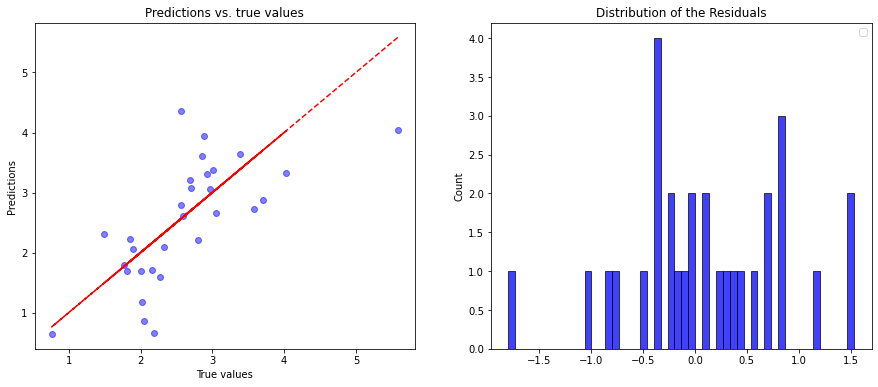

In [25]:
# Normalize the data using the MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train, y_train)
X_train_mm, y_train_mm = mm_scaler.transform(X_train, y_train)
X_test_mm = mm_scaler.transform(X_test)

# Train the model on the normalized data
LSR_mm = BasicLeastSquaresRegression()
LSR_mm.train(X_train_mm, y_train_mm)
y_pred_lsr_mm = LSR_mm.predict(X_test_mm)
y_pred_lsr_mm = mm_scaler.inverse_transform(y=y_pred_lsr_mm)

reg_res_mm = regression_report(y_test, y_pred_lsr_mm)

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


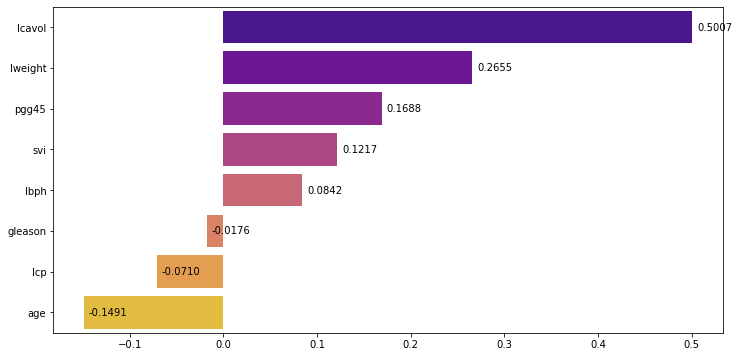

In [26]:
# Display the feature ranking
display_feature_ranking(df_train, LSR_mm._weights[:-1])

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.640561580795773
Root Mean Squared Error: 0.8003509110357612
R^2: 0.16766925068490113


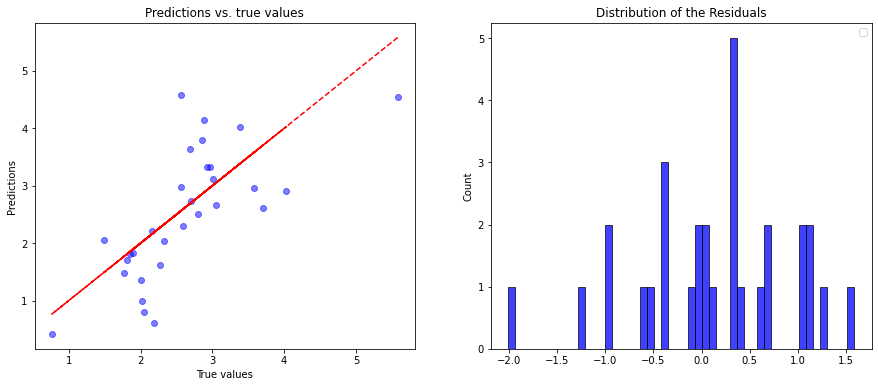

In [27]:
# Normalize the data using the LogTransformScaler
log_scaler = LogTransformScaler()
log_scaler.fit(X_train, y_train)
X_train_log, y_train_log = log_scaler.transform(X_train, y_train)
X_test_log, y_test_log = log_scaler.transform(X_test, y_test)

# Train the model on the normalized data
LSR_log = BasicLeastSquaresRegression()
LSR_log.train(X_train_log, y_train_log)
y_pred_lsr_log = LSR_log.predict(X_test_log)
y_pred_lsr_log = log_scaler.inverse_transform(y=y_pred_lsr_log)

reg_res_log = regression_report(y_test, y_pred_lsr_log)

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


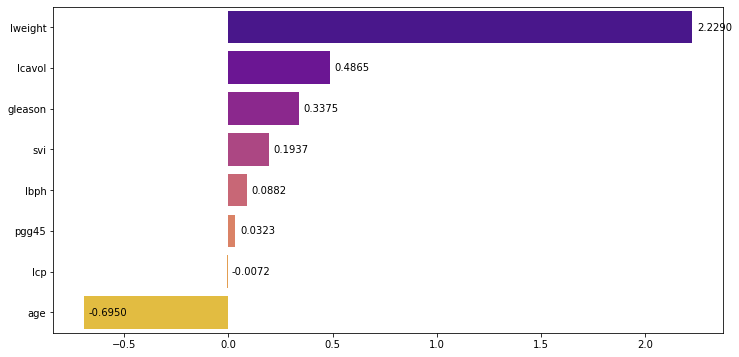

In [28]:
# Display the feature ranking
display_feature_ranking(df_train, LSR_log._weights[:-1])

In [29]:
naive_lsr_results = pd.concat([reg_res_og, reg_res_std, reg_res_mm, reg_res_log], axis=0, ignore_index=True)
naive_lsr_results.index = ["Original", "StandardScaler", "MinMaxScaler", "LogTransformScaler"]
naive_lsr_results

MSE      RMSE       R^2
Original            0.556181  0.745775  0.277312
StandardScaler      0.556181  0.745775  0.277312
MinMaxScaler        0.556181  0.745775  0.277312
LogTransformScaler  0.640562  0.800351  0.167669

**Questions:**

**1.1** What MSE loss score do you get with Least Squares?

The results I obtained using the vanilla least squares regression are as follows:

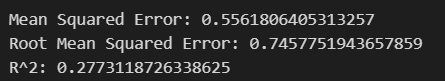

As can be seen, the results cannot be interpreted as reliable. The MSE loss is quite high and the R2 score is very low.

**1.2** What variables carry the greatest influence (i.e., are the most important) in the least squares regression?

The variables that carry the greatest influence in the least squares regression are as described in the following graph:
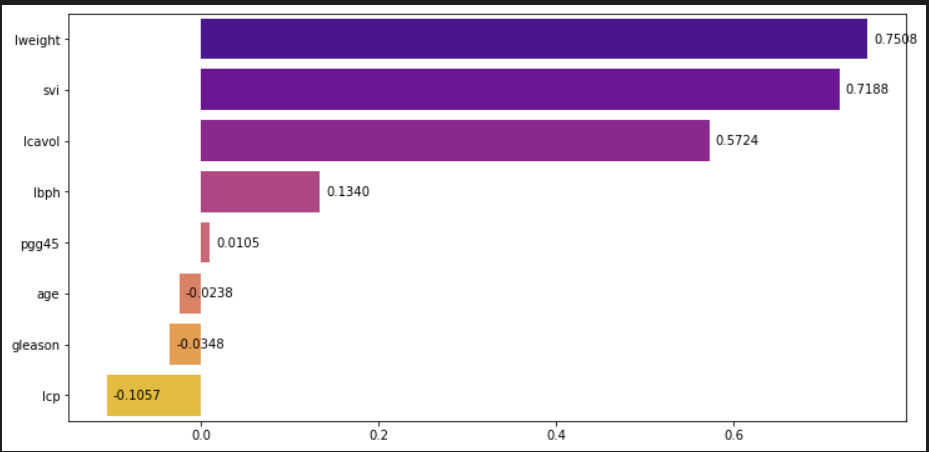


**1.3** Does normalizing the data improve performance (lower MSE loss)? If so, why?

Based on my testing, normalizing the data does NOT improve performance. We can verify this observation by looking at the below results:

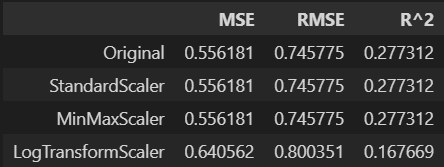

Here, it is evident that Standard Normalization, Min-Max Normalization do not have any effect on the performance of the model. Log Normalization, on the other hand, actually worsens the performance of the model. Let's examine why this is the case.

Least Squares Regression is a linear regression model and is formulated as follows in its simplest form:

$$ f(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$
Where:
- $(\beta_0)$ is the intercept.
- $(\beta_1, \beta_2, ..., \beta_n)$ are the coefficients of the features.
- $(x_1, x_2, ..., x_n)$ are the features.

We can see that each feature has a coefficient associated with it. The higher the coefficient, the more important the feature is and vice versa. Multiplication of a feature by a coefficient is a scaling operation. This means that the scale of the feature is directly proportional to the coefficient. Thus, **provided that our model was able to converge**, the model itself, by its mathematical nature, should theoretically be able to handle features with different scales. The key here, however, is that the model must be able to converge. This nuance bears more importance when dealing with a large dataset or when the implemented model iteratively updates its coefficients. In such cases, the model may not be able to converge if the features have drastically different scales as it may not be able to find the most optimal coefficients due to the size of the dataset. 

It should also be noted that both Standard Normalization and Min-Max Normalization are linear transformations and simply shifts the domain of values of the features which is a task that the model already handles.

In our case, we are dealing with a relatively small dataset and the model is not iteratively updating its coefficients. Thus, the model should be able to converge and find the most optimal coefficients. This is why normalizing the data does not improve performance for this particular model.

When it comes to Log Normalization, on the other hand, we are dealing with a different situation. Log Normalization is a non-linear transformation and we have in fact distorted the distribution of data which inevitably changes the data's nature and the underlying patterns. This is why Log Normalization is not guaranteed to improve performance and in our case, it actually worsens the performance of the model.

# 2. Linear Regression with L2 Regularization (Ridge)

Using the closed-form solution to Ridge Regression, implement a class called `RidgeRegression` that extends `BaseLearningAlgorithm` based on Hastie 3.41. Iterate through the regression penalty term, $\lambda$, and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.


In [31]:
class RidgeRegression(BaseLearningAlgorithm):
    """A Ridge Regression model implementing eq. 3.44."""
    
    def __init__(self, lambda_R: float):
        """Initializes the model."""
        self.lambda_R = lambda_R
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.44
        self._weights = np.linalg.inv(X_train.T @ X_train + self.lambda_R * np.eye(X_train.shape[1])) @ X_train.T @ y_train
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights
        
    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Ridge Regression"

Let's test this implementation by comparing the results of RidgeRegression when $\lambda = 0$ with the results of BasicLeastSquaresRegression. They should be the same.

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.5561806405313257
Root Mean Squared Error: 0.7457751943657859
R^2: 0.2773118726338625


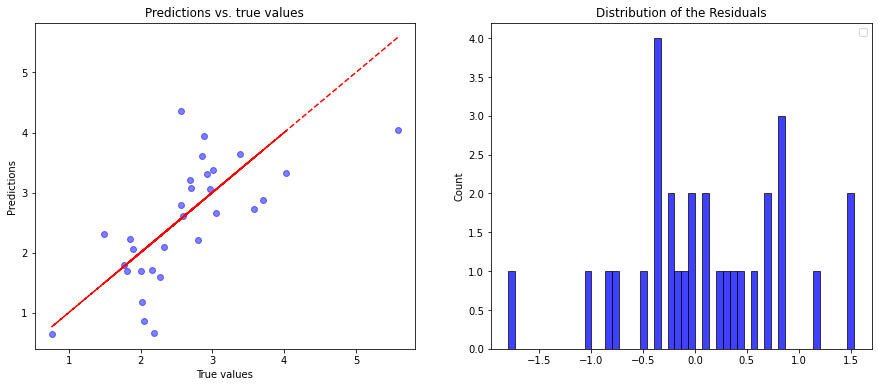

In [32]:
ridge_regression_model = RidgeRegression(lambda_R=0)
ridge_regression_model.train(X_train, y_train)

y_pred_ridge = ridge_regression_model.predict(X_test)
reg_res_ridge = regression_report(y_test, y_pred_ridge)

In [33]:
# let's see if the results are the same between BasicLeastSquaresRegression and RidgeRegression when lambda_R = 0
print(f"Are the results the same? {np.allclose(LSR._weights, ridge_regression_model._weights)}")

Are the results the same? True


Judging by the results, the two models seem to be equal. This is expected since the penalty term is zero. Let's see what happens when we increase the penalty term.

In [34]:
lambda_R_range = np.linspace(0, 150, 10000).tolist()

# Setting up a dataframe where we'll store the results and the weights
metrics_to_track = (
    ["lambda", "mse", "rmse", "r2"]
    + [f"w_{feature}" for feature in df_train.columns if feature != "lpsa"]
    + ["bias"]
)
print(f"Metrics to track: {metrics_to_track}")
rr_results = np.zeros((len(lambda_R_range), len(metrics_to_track)))

std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_std, y_train_std = std_scaler.transform(X_train, y_train)
X_test_std = std_scaler.transform(X_test)

for i, lambda_R in enumerate(lambda_R_range):
    print(f">>> Model {i}/{len(lambda_R_range)}. Lambda_R: {lambda_R}")

    ridge_regression_model = RidgeRegression(lambda_R=lambda_R)
    ridge_regression_model.train(X_train_std, y_train_std)
    y_pred_ridge = ridge_regression_model.predict(X_test_std)
    y_pred_ridge = std_scaler.inverse_transform(y=y_pred_ridge)

    ridge_reg_results = regression_report(y_test, y_pred_ridge, plot_results=False)
    rr_test_mse = ridge_reg_results["MSE"][0]
    rr_test_rmse = ridge_reg_results["RMSE"][0]
    rr_test_r2 = ridge_reg_results["R^2"][0]

    weights = ridge_regression_model._weights.tolist()
    # record the results
    rr_results[i] = [lambda_R, rr_test_mse, rr_test_rmse, rr_test_r2] + weights

Metrics to track: ['lambda', 'mse', 'rmse', 'r2', 'w_lcavol', 'w_lweight', 'w_age', 'w_lbph', 'w_svi', 'w_lcp', 'w_gleason', 'w_pgg45', 'bias']
>>> Model 0/10000. Lambda_R: 0.0
Mean Squared Error: 0.5561806405313204
Root Mean Squared Error: 0.7457751943657823
R^2: 0.27731187263386925
>>> Model 1/10000. Lambda_R: 0.015001500150015001
Mean Squared Error: 0.5560690446241787
Root Mean Squared Error: 0.7457003718814808
R^2: 0.2774568777478139
>>> Model 2/10000. Lambda_R: 0.030003000300030003
Mean Squared Error: 0.55595813943494
Root Mean Squared Error: 0.7456260050688549
R^2: 0.2776009853590561
>>> Model 3/10000. Lambda_R: 0.045004500450045004
Mean Squared Error: 0.5558479199209603
Root Mean Squared Error: 0.745552090682442
R^2: 0.2777442020198897
>>> Model 4/10000. Lambda_R: 0.060006000600060005
Mean Squared Error: 0.5557383810809287
Root Mean Squared Error: 0.7454786255023873
R^2: 0.2778865342289012
>>> Model 5/10000. Lambda_R: 0.075007500750075
Mean Squared Error: 0.5556295179544795
Root

In [35]:
# Let's sort the results by the MSE and R2
rr_results_df = pd.DataFrame(rr_results, columns=metrics_to_track)
rr_results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False).head(10)

lambda       mse      rmse        r2  w_lcavol  w_lweight     w_age  \
8074  121.122112  0.481537  0.693929  0.374302  0.181261   0.118970  0.007798   
8073  121.107111  0.481537  0.693929  0.374302  0.181272   0.118977  0.007796   
8075  121.137114  0.481537  0.693929  0.374302  0.181250   0.118962  0.007800   
8072  121.092109  0.481537  0.693929  0.374302  0.181283   0.118985  0.007794   
8076  121.152115  0.481537  0.693929  0.374302  0.181238   0.118954  0.007802   
8071  121.077108  0.481537  0.693929  0.374302  0.181294   0.118993  0.007792   
8077  121.167117  0.481537  0.693929  0.374302  0.181227   0.118946  0.007804   
8070  121.062106  0.481537  0.693929  0.374302  0.181305   0.119001  0.007790   
8078  121.182118  0.481537  0.693929  0.374302  0.181216   0.118939  0.007806   
8069  121.047105  0.481537  0.693929  0.374302  0.181316   0.119008  0.007788   

        w_lbph     w_svi     w_lcp  w_gleason   w_pgg45          bias  
8074  0.062284  0.126980  0.102290   0.060024  0.082571 -3.426079e-17  
8073  0.062289  0.126987  0.102293   0.060026  0.082574 -4.510281e-17  
8075  0.062279  0.126974  0.102287   0.060023  0.082569 -4.900594e-17  
8072  0.062293  0.126993  0.102296   0.060027  0.082577 -4.597017e-17  
8076  0.062275  0.126968  0.102284   0.060022  0.082566 -4.206704e-17  
8071  0.062298  0.126999  0.102299   0.060028  0.082580 -4.640385e-17  
8077  0.062270  0.126961  0.102282   0.060021  0.082563 -5.117434e-17  
8070  0.062302  0.127005  0.102302   0.060029  0.082583 -5.724587e-17  
8078  0.062265  0.126955  0.102279   0.060019  0.082560 -5.854692e-17  
8069  0.062307  0.127012  0.102305   0.060031  0.082586 -7.025630e-17

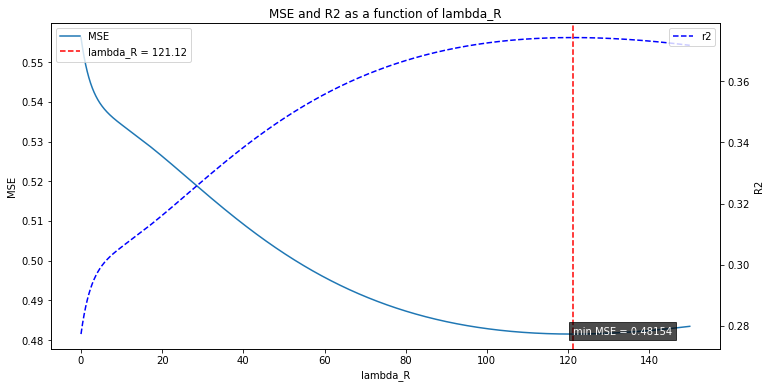

In [36]:
# let's pot the MSE and R2 as a function of lambda_R
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rr_results_df["lambda"].values, rr_results_df["mse"].values, label="MSE")

# Add a vertical line at the minimum MSE
min_mse = rr_results_df["mse"].min()
min_mse_lambda = rr_results_df[rr_results_df["mse"] == min_mse]["lambda"].values[0]
ax.axvline(
    min_mse_lambda,
    color="red",
    linestyle="--",
    label=f"lambda_R = {min_mse_lambda:.2f}",
)
# Add text annotation for the minimum MSE with a black background and white text
ax.text(
    min_mse_lambda,
    min_mse,
    f"min MSE = {min_mse:.5f}",
    bbox=dict(facecolor="black", alpha=0.7),
    color="white",
)


# Create a twin Axes sharing the xaxis for the r2
ax2 = ax.twinx()
ax2.plot(rr_results_df["lambda"].values, rr_results_df["r2"].values, "b--", label="r2")
ax.set_xlabel("lambda_R")
ax.set_ylabel("MSE")
ax2.set_ylabel("R2")
ax.set_title("MSE and R2 as a function of lambda_R")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

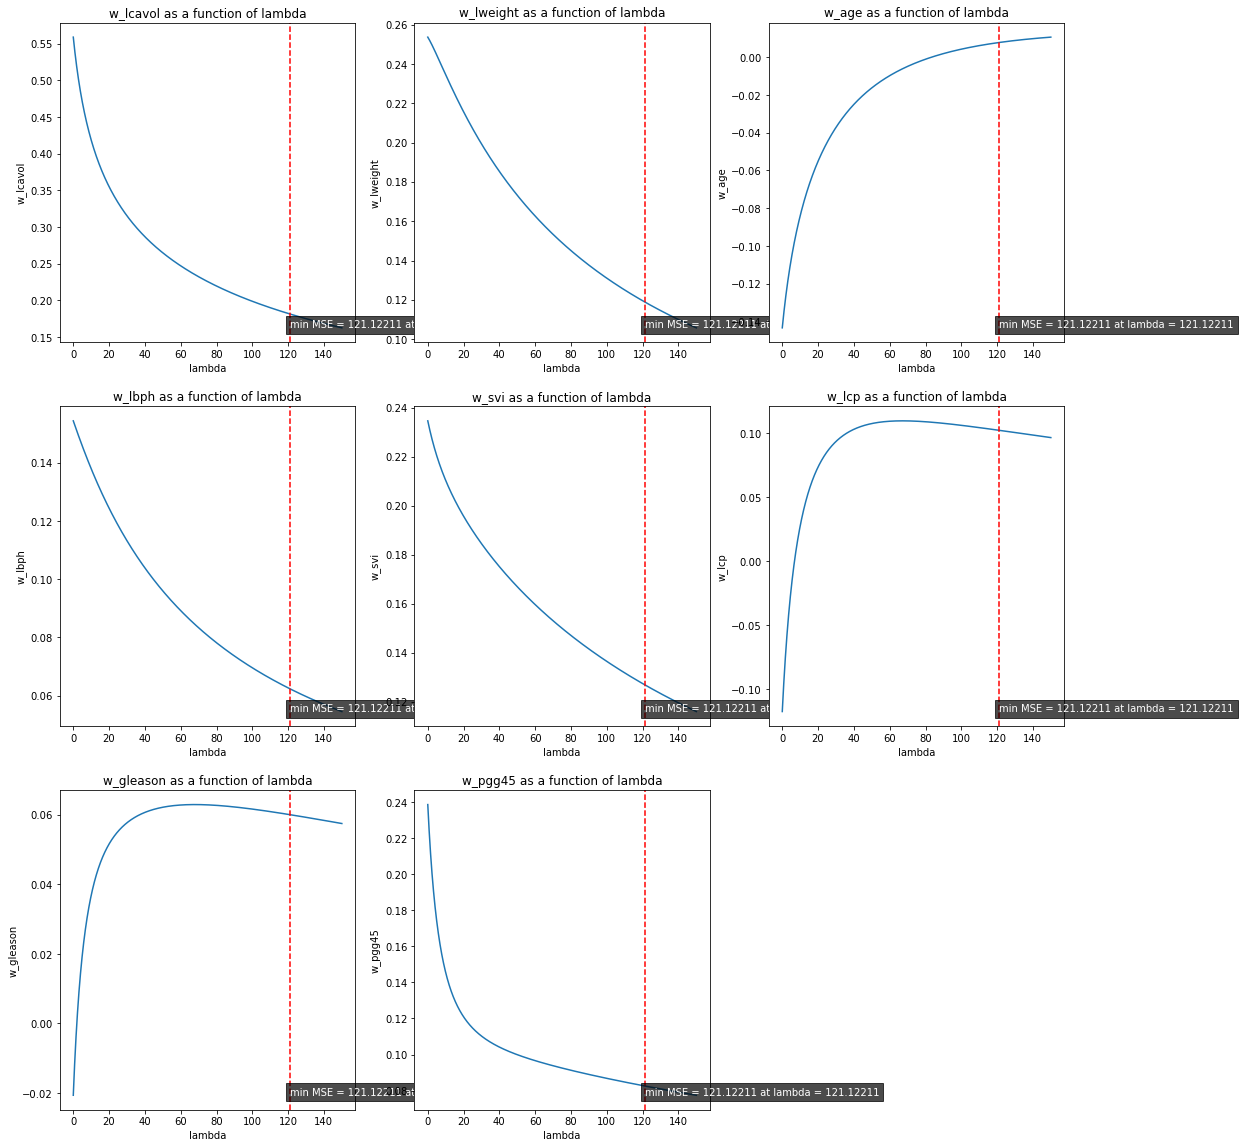

In [35]:
# Diplay a plot of the weights as a function of lambda_R
plot_weights_vs_model_param(rr_results_df, "lambda")

**Questions:**


**2.1** What $\lambda$ do you get the best performance (i.e., lowest MSE)?

The best performance for the Ridge Regression model is achieved when the penalty term is equal to 121.122112. It should be noted that these results are based on the test set.
The results are as follows:
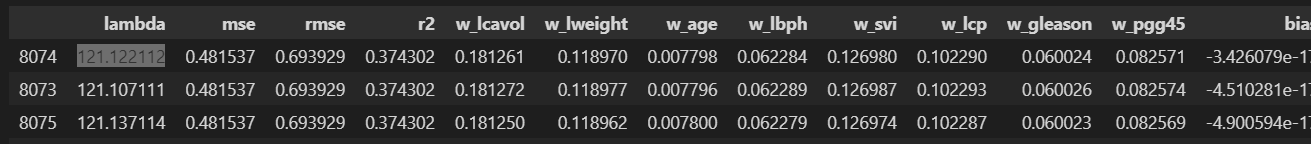

**2.2** Compare the results from part 1, when $\lambda = 0$. Why are the results similar or different?
This was the first ever step I took when checking for the validity of my implementation of the Ridge Regression model. I compared the results of the Ridge Regression model when the penalty term is equal to 0 with the results of the Basic Least Squares Regression model. To understand this, let's take a look at the formula for Ridge Regression:

$$ \hat{\beta} = (X^T X + \lambda I)^{-1} X^T y $$
Where:
- $(\hat{\beta})$ is the coefficient vector.
- $(X)$ is the feature matrix.
- $(y)$ is the target vector.
- $(\lambda)$ is the penalty term.

We can see that when the penalty term is equal to 0, the formula for Ridge Regression is reduced to the formula for Basic Least Squares Regression. This is why the results are similar.

$$ \hat{\beta} = (X^T X)^{-1} X^T y $$


**2.3** Compare the weights with the weights from part 1? If you were to rank descending by the absolute value of the weights, how different is the ordering with part 1? Is the most important variable in part 1 the same as in part 2? If not, can you provide a reason?

To answer this question, let's take the best performing Ridge Regression model and compare its weights with the weights of the Basic Least Squares Regression model.

In [39]:
rr_results_df_srt = rr_results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False)
rr_results_df_srt.head()

lambda       mse      rmse        r2  w_lcavol  w_lweight     w_age  \
8074  121.122112  0.481537  0.693929  0.374302  0.181261   0.118970  0.007798   
8073  121.107111  0.481537  0.693929  0.374302  0.181272   0.118977  0.007796   
8075  121.137114  0.481537  0.693929  0.374302  0.181250   0.118962  0.007800   
8072  121.092109  0.481537  0.693929  0.374302  0.181283   0.118985  0.007794   
8076  121.152115  0.481537  0.693929  0.374302  0.181238   0.118954  0.007802   

        w_lbph     w_svi     w_lcp  w_gleason   w_pgg45          bias  
8074  0.062284  0.126980  0.102290   0.060024  0.082571 -3.426079e-17  
8073  0.062289  0.126987  0.102293   0.060026  0.082574 -4.510281e-17  
8075  0.062279  0.126974  0.102287   0.060023  0.082569 -4.900594e-17  
8072  0.062293  0.126993  0.102296   0.060027  0.082577 -4.597017e-17  
8076  0.062275  0.126968  0.102284   0.060022  0.082566 -4.206704e-17

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

Text(0.5, 1.0, 'Basic Least Squares Regression')

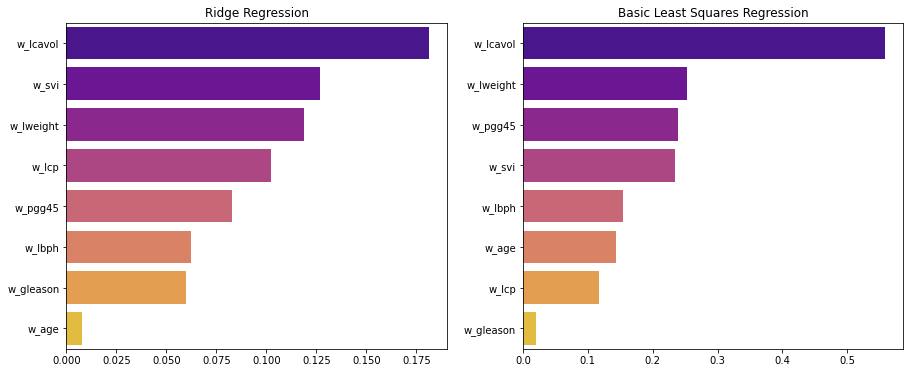

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# We will plot the coefficients in a descending order for both Ridge Regression and Basic Least Squares Regression
# Plot the coefficients for Ridge Regression

rr_weights = rr_results_df_srt.iloc[0, 4:-1].abs().sort_values(ascending=False)

sns.barplot(
    y=rr_weights.index,
    x=rr_weights.values,
    ax=axes[0],
    palette="plasma",
)
axes[0].set_title("Ridge Regression")

lsr_std_weights = pd.Series(np.abs(LSR_std._weights[:-1]), index=rr_results_df_srt.columns[4:-1]).sort_values(ascending=False)

sns.barplot(
    y=lsr_std_weights.index,
    x=lsr_std_weights.values,
    ax=axes[1],
    palette="plasma",
)
axes[1].set_title("Basic Least Squares Regression")

From the above graph, it is evident that the importance placed on different features are quite different depending on the model. The most important feature in both the Basic Least Squares Regression and the Ridge Regression models is ``lcavol`` while the ``lweight`` feature being in the top3 for the both models. As to why this happens, the regularization term in the Ridge Regression model penalizes the coefficients of the features in order to prevent overfitting and to ensure that one feature does not dominate the model as this will cause the model to be biased towards that feature. It is for this reason that the weight differences between the most important feature and the rest of the features have been significantly reduced in RidgeRegression.

If we compare the results obtained by the two models, we can see that the Ridge Regression model performs notably better as it was able to converge to a more optimal solution. Despite some of the variables having more control over the model, the difference between the weights of the features are not as drastic. This has apparently allowed the model to generalize better and thus, perform better on the test set.

# 3. Linear Regression with L1 Regularization (Lasso)

Unlike Ridge Regression, there is no closed-form solution for Lasso, meaning there is no normal equation we can solve to immediately get all of our ideal model parameters. While it can be solved by minimizing one coordinate a time using a technique called [Coordinate Descent](http://www.adeveloperdiary.com/data-science/machine-learning/introduction-to-coordinate-descent-using-least-squares-regression/), here you can implement your solution using Scikit-Learn Lasso inside a class called `LassoRegression` which also extends `BaseLearningAlgorithm`. Like part 2, iterate through the regression penalty term, $\alpha$ , and plot (a) MSE loss as a function of $\alpha$, and (b) each coefficient weight as a function of $\alpha$.

**Note**: here we swap notation a little, replacing $\lambda$ with $\alpha$ to fit with the Scikit-Learn convention.




In [60]:
class LassoRegression(BaseLearningAlgorithm):
    """A Lasso Regression model implementing eq. 3.52."""

    def __init__(self, alpha: float):
        """Initializes the model."""
        self.alpha = alpha

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.52
        self._model = Lasso(alpha=self.alpha, fit_intercept=False)
        self._model.fit(X_train, y_train)
        self._weights = self._model.coef_

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights

    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Lasso Regression"

In [61]:
# let's try a few values of alpha
alpha_range = np.linspace(0, 1, 10000).tolist()

# Setting up a dataframe where we'll store the results and the weights
metrics_to_track = (
    ["alpha", "mse", "rmse", "r2"]
    + [f"w_{feature}" for feature in df_train.columns if feature != "lpsa"]
    + ["bias"]
)
print(f"Metrics to track: {metrics_to_track}")
lr_results = np.zeros((len(alpha_range), len(metrics_to_track)))

for i, alpha in enumerate(alpha_range):
    print(f">>> Model {i}/{len(alpha_range)}. alpha: {alpha}")

    lasso_regression_model = LassoRegression(alpha=alpha)
    # Train the model on normalized data
    lasso_regression_model.train(X_train_std, y_train_std)
    y_pred_lasso = lasso_regression_model.predict(X_test_std)
    y_pred_lasso = std_scaler.inverse_transform(y=y_pred_lasso)

    lasso_reg_results = regression_report(y_test, y_pred_lasso, plot_results=False)
    lr_test_mse = lasso_reg_results["MSE"][0]
    lr_test_rmse = lasso_reg_results["RMSE"][0]
    lr_test_r2 = lasso_reg_results["R^2"][0]

    weights = lasso_regression_model._weights.tolist()
    # record the results
    lr_results[i] = [alpha, lr_test_mse, lr_test_rmse, lr_test_r2] + weights

Metrics to track: ['alpha', 'mse', 'rmse', 'r2', 'w_lcavol', 'w_lweight', 'w_age', 'w_lbph', 'w_svi', 'w_lcp', 'w_gleason', 'w_pgg45', 'bias']
>>> Model 0/10000. alpha: 0.0
Mean Squared Error: 0.5561806405313202
Root Mean Squared Error: 0.7457751943657822
R^2: 0.2773118726338696
>>> Model 1/10000. alpha: 0.00010001000100010001
Mean Squared Error: 0.5558823028982375
Root Mean Squared Error: 0.7455751490616069
R^2: 0.27769952558268385
>>> Model 2/10000. alpha: 0.00020002000200020003
Mean Squared Error: 0.5555859565105484
Root Mean Squared Error: 0.7453763858015281
R^2: 0.2780845911537655
>>> Model 3/10000. alpha: 0.00030003000300030005
Mean Squared Error: 0.5552914341931563
Root Mean Squared Error: 0.74517879344031
R^2: 0.27846728657052855
>>> Model 4/10000. alpha: 0.00040004000400040005
Mean Squared Error: 0.5549987241529961
Root Mean Squared Error: 0.7449823649946327
R^2: 0.27884762715660605
>>> Model 5/10000. alpha: 0.0005000500050005
Mean Squared Error: 0.5547081139550358
Root Mean S

C:\Users\togru\AppData\Local\Temp\ipykernel_13528\607879693.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._model.fit(X_train, y_train)
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.316e+00, tolerance: 6.700e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

Mean Squared Error: 0.5373988209216358
Root Mean Squared Error: 0.7330749081244261
R^2: 0.30171653013738253
>>> Model 126/10000. alpha: 0.012601260126012601
Mean Squared Error: 0.5373494003838151
Root Mean Squared Error: 0.7330411996496616
R^2: 0.3017807460293579
>>> Model 127/10000. alpha: 0.012701270127012701
Mean Squared Error: 0.53730110942662
Root Mean Squared Error: 0.7330082601353275
R^2: 0.30184349417066436
>>> Model 128/10000. alpha: 0.012801280128012802
Mean Squared Error: 0.5372539480500513
Root Mean Squared Error: 0.7329760896850942
R^2: 0.30190477456130116
>>> Model 129/10000. alpha: 0.012901290129012902
Mean Squared Error: 0.5372079162541085
Root Mean Squared Error: 0.7329446884002287
R^2: 0.30196458720126906
>>> Model 130/10000. alpha: 0.013001300130013002
Mean Squared Error: 0.5371630140387922
Root Mean Squared Error: 0.7329140563795951
R^2: 0.3020229320905673
>>> Model 131/10000. alpha: 0.013101310131013101
Mean Squared Error: 0.5371192414041019
Root Mean Squared Error

In [62]:
# Let's sort the results by the MSE and R2
lr_results_df = pd.DataFrame(lr_results, columns=metrics_to_track)
lr_results_df.sort_values(
    by=["mse", "r2"], ascending=[True, False], inplace=False
).head(10)

alpha       mse      rmse        r2  w_lcavol  w_lweight  w_age  \
1815  0.181518  0.390297  0.624738  0.492857  0.481664   0.120860    0.0   
1816  0.181618  0.390297  0.624738  0.492857  0.481649   0.120770    0.0   
1814  0.181418  0.390297  0.624738  0.492857  0.481679   0.120950    0.0   
1817  0.181718  0.390297  0.624738  0.492857  0.481634   0.120680    0.0   
1813  0.181318  0.390297  0.624738  0.492857  0.481694   0.121040    0.0   
1818  0.181818  0.390298  0.624738  0.492856  0.481619   0.120590    0.0   
1812  0.181218  0.390298  0.624738  0.492856  0.481709   0.121130    0.0   
1819  0.181918  0.390298  0.624738  0.492856  0.481604   0.120500    0.0   
1811  0.181118  0.390298  0.624738  0.492856  0.481725   0.121221    0.0   
1820  0.182018  0.390298  0.624738  0.492856  0.481588   0.120409    0.0   

      w_lbph     w_svi  w_lcp  w_gleason   w_pgg45  bias  
1815     0.0  0.096842    0.0        0.0  0.021583  -0.0  
1816     0.0  0.096797    0.0        0.0  0.021511  -0.0  
1814     0.0  0.096887    0.0        0.0  0.021655  -0.0  
1817     0.0  0.096753    0.0        0.0  0.021440  -0.0  
1813     0.0  0.096932    0.0        0.0  0.021726  -0.0  
1818     0.0  0.096708    0.0        0.0  0.021368  -0.0  
1812     0.0  0.096977    0.0        0.0  0.021798  -0.0  
1819     0.0  0.096663    0.0        0.0  0.021296  -0.0  
1811     0.0  0.097021    0.0        0.0  0.021870  -0.0  
1820     0.0  0.096618    0.0        0.0  0.021225  -0.0

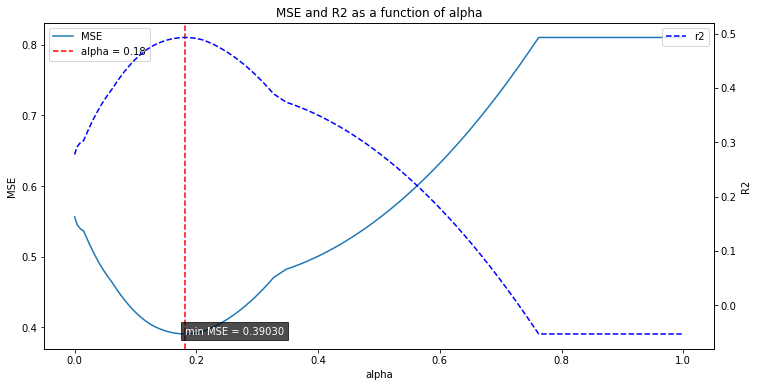

In [63]:
# let's pot the MSE and R2 as a function of alpha
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(lr_results_df["alpha"].values, lr_results_df["mse"].values, label="MSE")

# Add a vertical line at the minimum MSE
min_mse_lr = lr_results_df["mse"].min()
min_mse_alpha = lr_results_df[lr_results_df["mse"] == min_mse_lr]["alpha"].values[0]
ax.axvline(
    min_mse_alpha, color="red", linestyle="--", label=f"alpha = {min_mse_alpha:.2f}"
)
# Add text annotation for the minimum MSE with a black background and white text
ax.text(
    min_mse_alpha,
    min_mse_lr,
    f"min MSE = {min_mse_lr:.5f}",
    bbox=dict(facecolor="black", alpha=0.7),
    color="white",
)

# Create a twin Axes sharing the xaxis for the r2
ax2 = ax.twinx()
ax2.plot(lr_results_df["alpha"].values, lr_results_df["r2"].values, "b--", label="r2")
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax2.set_ylabel("R2")
ax.set_title("MSE and R2 as a function of alpha")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

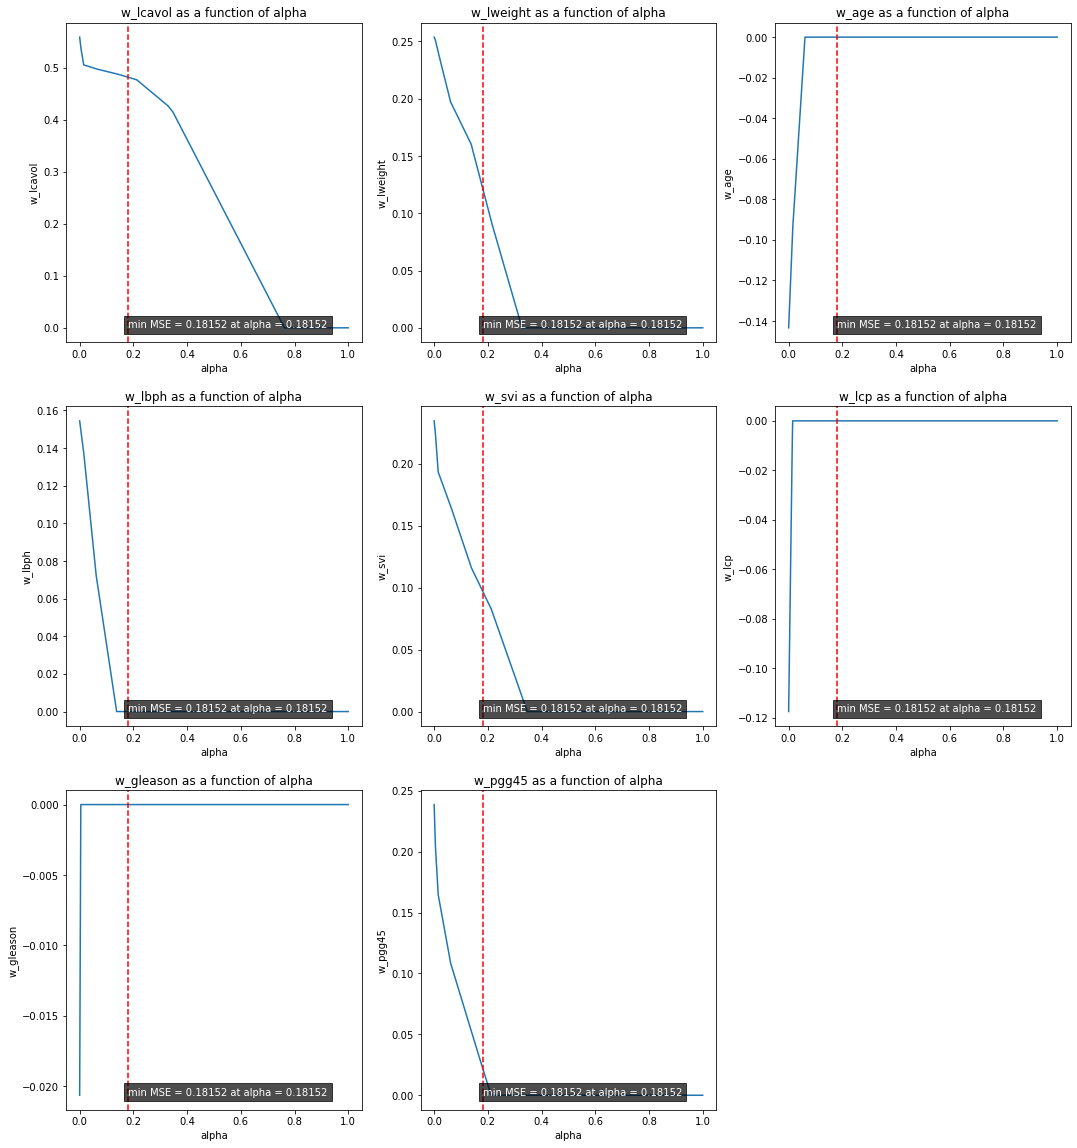

In [66]:
# Diplay a plot of the weights as a function of alpha
plot_weights_vs_model_param(lr_results_df, model_param="alpha")

In [67]:
lr_results_df_srt = lr_results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False)
lr_results_df_srt.head()

alpha       mse      rmse        r2  w_lcavol  w_lweight  w_age  \
1815  0.181518  0.390297  0.624738  0.492857  0.481664    0.12086    0.0   
1816  0.181618  0.390297  0.624738  0.492857  0.481649    0.12077    0.0   
1814  0.181418  0.390297  0.624738  0.492857  0.481679    0.12095    0.0   
1817  0.181718  0.390297  0.624738  0.492857  0.481634    0.12068    0.0   
1813  0.181318  0.390297  0.624738  0.492857  0.481694    0.12104    0.0   

      w_lbph     w_svi  w_lcp  w_gleason   w_pgg45  bias  
1815     0.0  0.096842    0.0        0.0  0.021583  -0.0  
1816     0.0  0.096797    0.0        0.0  0.021511  -0.0  
1814     0.0  0.096887    0.0        0.0  0.021655  -0.0  
1817     0.0  0.096753    0.0        0.0  0.021440  -0.0  
1813     0.0  0.096932    0.0        0.0  0.021726  -0.0

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

Text(0.5, 1.0, 'Ridge Regression')

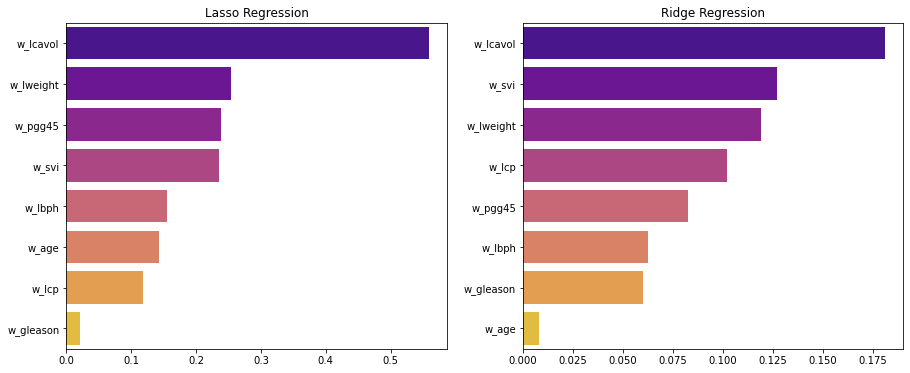

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# We will plot the coefficients in a descending order for both Lasso Regression and Ridge Regression
# Plot the coefficients for Lasso Regression

lr_weights = lr_results_df.iloc[0, 4:-1].abs().sort_values(ascending=False)

sns.barplot(
    y=lr_weights.index,
    x=lr_weights.values,
    ax=axes[0],
    palette="plasma",
)
axes[0].set_title("Lasso Regression")

rr_weights = rr_results_df_srt.iloc[0, 4:-1].abs().sort_values(ascending=False)

sns.barplot(
    y=rr_weights.index,
    x=rr_weights.values,
    ax=axes[1],
    palette="plasma",
)
axes[1].set_title("Ridge Regression")

In [72]:
# Let's compare the train and test MSE scores of the models developed so far
# Initialize an empty dataframe to store the results
models_results = pd.DataFrame(columns=["model", "train_mse", "test_mse"])

# Initialize the RidgeRegression model with the best weights
best_RR_model = RidgeRegression(lambda_R=rr_results_df_srt.iloc[0, 0])
best_RR_model._weights = rr_results_df_srt.iloc[0, 4:].values

# Initialize the LassoRegression model with the best weights
best_LR_model = LassoRegression(alpha=lr_results_df_srt.iloc[0, 0])
best_LR_model._weights = lr_results_df_srt.iloc[0, 4:].values

# get the train and test MSE scores for LSR based on the StandardScaled data
y_train_lsr = LSR_std.predict(X_train_std)
y_train_lsr = std_scaler.inverse_transform(y=y_train_lsr)
train_mse_lsr = metrics.mean_squared_error(y_train, y_train_lsr)
test_mse_lsr = metrics.mean_squared_error(y_test, y_pred_lsr_std)
models_results.loc[0] = ["LSR", train_mse_lsr, test_mse_lsr]

# get the train and test MSE scores for RR based on the StandardScaled data
y_train_rr = best_RR_model.predict(X_train_std)
y_train_rr = std_scaler.inverse_transform(y=y_train_rr)
train_mse_rr = metrics.mean_squared_error(y_train, y_train_rr)
y_pred_rr = best_RR_model.predict(X_test_std)
y_pred_rr = std_scaler.inverse_transform(y=y_pred_rr)
test_mse_rr = metrics.mean_squared_error(y_test, y_pred_rr)
models_results.loc[1] = ["RR", train_mse_rr, test_mse_rr]

# get the train and test MSE scores for LR based on the StandardScaled data
y_train_lr = best_LR_model.predict(X_train_std)
y_train_lr = std_scaler.inverse_transform(y=y_train_lr)
train_mse_lr = metrics.mean_squared_error(y_train, y_train_lr)
y_pred_lr = best_LR_model.predict(X_test_std)
y_pred_lr = std_scaler.inverse_transform(y=y_pred_lr)
test_mse_lr = metrics.mean_squared_error(y_test, y_pred_lr)
models_results.loc[2] = ["LR", train_mse_lr, test_mse_lr]

# Replace the index with the model names
models_results.set_index("model", inplace=True)

In [73]:
models_results

train_mse  test_mse
model                     
LSR     0.431568  0.556181
RR      0.679123  0.481537
LR      0.591608  0.390297

**Questions:**

**3.1** Under what conditions would you prefer L2 or L1 regression over vice versa? (Consider the discussion in Hastie 3.6.)

**Considering that Lasso Regression is a subset selection method, the below are some of the situations when this method might be preferred:**
- When we have a large number of features and we suspect that some of them are not relevant to the model. In such cases, Lasso Regression will be able to zero out the coefficients of the irrelevant features and thus, reduce the dimensionality of the data. This will allow the model to generalize better and thus, presumably perform better on the test set.
- If the case when features are highly correlated with each other and we want to select the few that are most relevant to the model. In such cases, Lasso Regression will be able to zero out the coefficients (as it produces sparse coefficients) of the features that are not relevant to the model and thus, select the most relevant features.
- Arguably, Lasso Regression is more interpretable than Ridge Regression. Since Lasso Regression produces sparse coefficients, it might be easier to logically explain the model to a non-technical audience and not have every variable clutter the board during decision making.

**Considering that Ridge Regression is a shrinkage method, here are a few situations where it is especially useful:**

- When every feature is potentially useful (even if they are highly correlated) and we do not want to reduce the dimensionality of the data. In such cases, Ridge Regression will be able to shrink the coefficients of the features that are not relevant to the model and thus, reduce the variance of the model. This will allow the model to generalize well while maintaining the dimensionality of the data. However, this decision requires domain knowledge and should not be made lightly especially if the dataset is large.
- Every bit of gain in performance is important. As discussed in Hastie 3.6, Ridge Regression is very likely to outperform all shrinkage or subset selection based methods when the features are lightly or very poorly correlated with each other. As the shrinkage is applied smoothly, not in discrete steps, Ridge Regression will be able to converge to a more optimal solution and thus, perform better on the test set.
- Ridge Regression is more robust as it has a closed-form solution. This means that it is less sensitive to the choice of the penalty term and thus, it is easier to tune the model. This is especially useful when the dataset is large and the model is iteratively updating its coefficients.
- When var


**3.2** Why do some coefficients become zero? Do you think this may be a method of subset selection as described in Hastie 3.3?

L1 Regularization employs the absolute value term. which is non-differentiable at 0. It is possible that when optimizing, minmizing the loss in this case, this "corner" is judged to be the most optimal solution. Considering the fact that Lasso Regression iteratively checks for the features, some of the coefficients may yield the lowest loss when they are zeroed out. This is why some of the coefficients become zero. This can easily be interpreted as subset selection since the model indeed performs the optimization process by iteratively zeroing out the coefficients of the features that are not relevant to the model.


**3.3** Which method performs better (i.e., has the lower MSE)?

Lasso Regression performs better than Ridge Regression in our case. This is most likely due to the fact that some variables have relatively high correlation with each other (as displayed before) and Lasso Regression is able to zero out the coefficients of the features that are not relevant to the model allowing the model to reduce the effect of overfitting.

**3.4** Comparing the relative ranking of the weights at the lowest MSE, do Ridge Regression and Lasso Regression “agree” on the most important weights?

If we look at the below graph, we can see that top 3 most important features are the same with the exception of `ppg45` and `svi`. 
A rather interesting fact is that the variable `lcp` was judged to be significantly more important by Ridge Regression compared to Lasso Regression. This is an interesting development since lcp is quite highly correlated with `lweight` and `lcavol`, 2 variables that are deemed to be very important by both models. Lasso Regression was able to zero out the coefficient of `lcp` and thus, reduce the effect of overfitting. This chould as well be a strong reason why Lasso Regression performed better than Ridge Regression in our case.

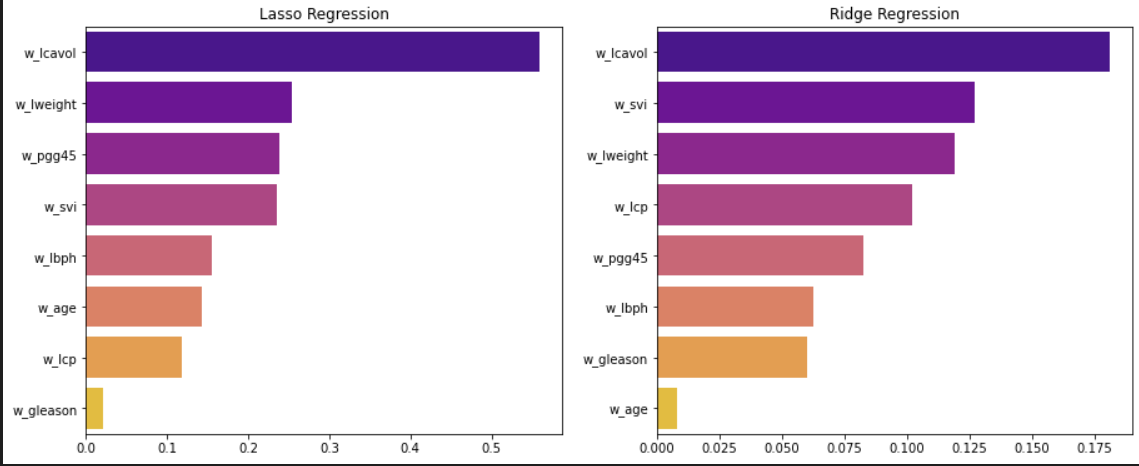

**3.5** In your own words, define **bias** and **variance**. Describe how bias and variance affected the results of parts 1, 2, and 3.

This question can easily be answered by paying attention to the *MSE* scores for all 3 models based on both the training and test sets. When it comes to how these terms can be defined:
- **Bias** is the difference between the expected value of the predictions and the actual value of the target variable. Simply judging by the training data, bias is the error introduced as a result of model's assumptions and simplifications. A model with high bias will have been unable to capture the underlying patterns in the data. This can easily be spotted by poor performance on the training set.
- **Variance**, on the other hand, is a measure of the error induced due to the unnecessarily high complexity in the data. This can be self-evident when the model performs well on the training set but poorly on the test set. As an indicator of poor generalization, high variance is most offen a result of overfitting.

> Balancing bias and variance is a key challenge in building any type of machine learning model. The goal is to find a model that appropriately captures the patterns in the data, while also generalizing well on new data. This is called the bias-variance tradeoff.

Now, let's take a look at the below table:

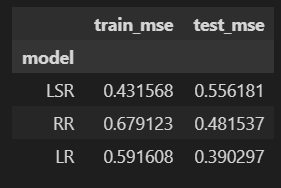

Here, it is lucid that the `Basic Least Squares Regression` model has the** lowest training error** while showing the **worst performance on the test set**. This is a clear indication of overfitting as the model is displaying high variance and low bias. This is most likely due to the correlations between the features. The model was unable to generalize well and thus, performed poorly on the test set.

`Lasso Regression` has the **lowest test error** while having a **training error that is only slightly higher** than the training error of the `Basic Least Squares Regression` model. This is a clear indication of the model generalizing well and thus, having low variance and relatively high bias. I believe the underlying cause of this phenomenon is the fact that Lasso Regression is able to zero out the coefficients of the features that are not relevant to the model. A fact taht was proven by its ability to demote the importance of the `lcp` feature as stated above.

`Ridge Regression` sits between the two aforementioned models. It has a **training error that is higher than the training error of the `Lasso Regression` model** while having a **test error that is marginally lower than the test error of the `Basic Least Squares Regression` model**. This is a clear indication of the model generalizing well and thus, having low variance and relatively high bias. I believe the underlying cause of this phenomenon is the fact that Ridge Regression is able to shrink the coefficients of the features that are not relevant to the model. A fact taht was proven by its ability to demote the importance of the `lcp` feature as stated above.


# 4.  Iterative Optimization with Gradient Descent
Implement a class called `RidgeRegressionGradDescent` that extends `BaseLearningAlgorithm` that performs linear regression with L2 regularization using [gradient descent](https://www.deeplearningbook.org/contents/numerical.html), Goodfellow 4.5. Plot both training and test MSE loss result vs. iteration.  Iterate through the regression penalty term, $\lambda$ , and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.


Here, we'll be using the equation of the gradient of the loss function with respect to the weights. The loss function is the MSE loss function and including the L2 regularization term, it is defined as:

$$ L(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 $$

In order to find the gradient of the loss function, we need to find the partial derivative of the loss function with respect to the weights. The partial derivative of the loss function with respect to the weights wil be as follows in its matrix form:

$$ \frac{\partial L(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = 2 \boldsymbol{X}^T (\boldsymbol{X} \boldsymbol{\beta} - \boldsymbol{Y}) + 2 \lambda \boldsymbol{\beta} $$

In [108]:
class RidgeRegressionGradDescent(BaseLearningAlgorithm):
    """A Ridge Regression model implementing eq. 4.21 and 4.22. from Goodfellow."""
    
    def __init__(self, lambda_R: float, learning_rate: float, max_iter: int, tol: float):
        """Initializes the model."""
        self.lambda_R = lambda_R
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray, 
              X_test: Union[np.ndarray, None] = None, y_test: Union[np.ndarray, None] = None
              ) -> Union[pd.DataFrame, None]:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.44
        self._weights = np.random.randn(X_train.shape[1])
        
        # Initialize a dataframe to store the results
        self._results = pd.DataFrame(columns=["iter", "train_mse", "test_mse"])
        
        for i in range(self.max_iter):
            # Compute the predictions
            y_pred = X_train @ self._weights        
                      
            # Compute the residuals
            residuals = y_pred - y_train
            
            # Terminate if the loss or the predictions contain NaNs
            if np.isnan(residuals).any() or np.isnan(y_pred).any():
                print(f"NaNs encountered at iteration {i}.")
                break
            
            # Terminate if the predictions contain Infs
            if np.isinf(y_pred).any():
                print(f"Infs encountered at iteration {i}.")
                break
            
            # Compute the train MSE
            train_mse = metrics.mean_squared_error(y_train, y_pred)
            
            if X_test is not None and y_test is not None:
            # Compute the test MSE
                y_pred_test = self.predict(X_test)
                test_mse = metrics.mean_squared_error(y_test, y_pred_test)
            else:
                test_mse = np.nan
            # Record the results
            self._results.loc[i] = [i, train_mse, test_mse]
             
            # Compute the gradient without regularizing the bias term
            grad = 2 * X_train.T @ residuals
            # Regularize the weights except for the bias term
            grad[:-1] += 2 * self.lambda_R * self._weights[:-1]
            # Update the weights
            self._weights = self._weights - self.learning_rate * grad
            
            if np.linalg.norm(grad) < self.tol:
                print(f"Converged after {i} iterations.")
                break
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights
        
    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Ridge Regression Gradient Descent"

Let's test this implementation by comparing the results of RidgeRegressionGradDescent when $\lambda = 0$ with the results of BasicLeastSquaresRegression. They should be the same. For this case we will test based on a fixed number of iterations and a fixed learning rate.

Converged after 1416 iterations.
Mean Squared Error: 0.5554496392625207
Root Mean Squared Error: 0.7452849383038146
R^2: 0.2782617186003642


c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


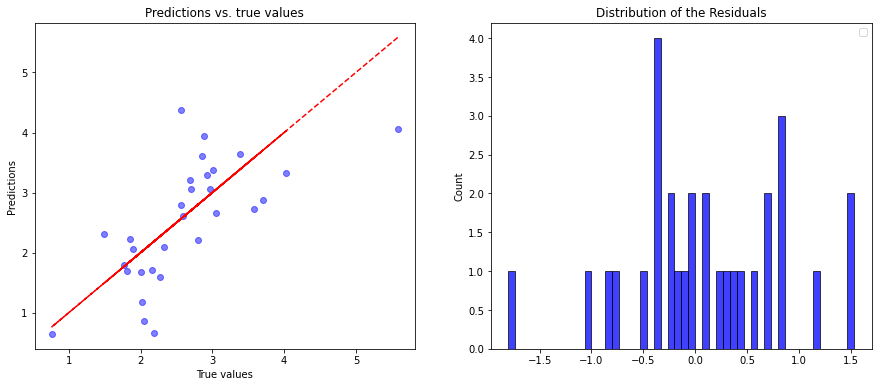

In [109]:
# Let's try Lambda_R = 0.1, learning_rate = 0.01, max_iter = 10000, tol = 1e-8
lambda_R = 0.1
learning_rate = 0.001
max_iter = 10000
tol = 1e-12

std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_std, y_train_std = std_scaler.transform(X_train, y_train)
X_test_std = std_scaler.transform(X_test)
y_test_std = std_scaler.transform(y=y_test)

ridge_regression_grad_descent_model = RidgeRegressionGradDescent(
    lambda_R=lambda_R, learning_rate=learning_rate, max_iter=max_iter, tol=tol
)
ridge_regression_grad_descent_model.train(X_train_std, y_train_std, X_test_std, y_test_std)
y_pred_ridge_grad_descent = ridge_regression_grad_descent_model.predict(X_test_std)
y_pred_ridge_grad_descent = std_scaler.inverse_transform(y=y_pred_ridge_grad_descent)
# print(y_pred_ridge_grad_descent)
reg_res_ridge_grad_descent = regression_report(y_test, y_pred_ridge_grad_descent)

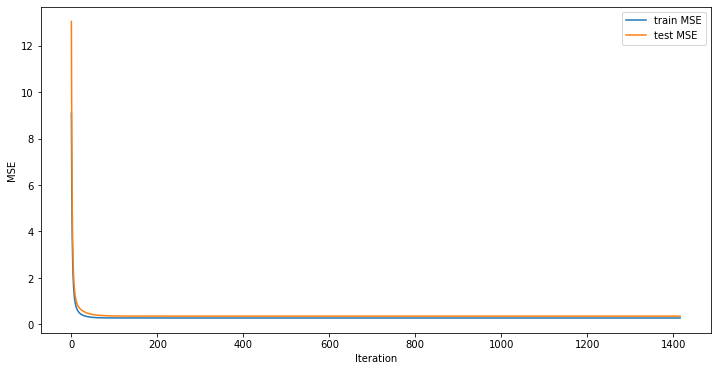

In [110]:
# Let's plot the train and test MSE as a function of the number of iterations
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ridge_regression_grad_descent_model._results["iter"].values, ridge_regression_grad_descent_model._results["train_mse"].values, label="train MSE")
ax.plot(ridge_regression_grad_descent_model._results["iter"].values, ridge_regression_grad_descent_model._results["test_mse"].values, label="test MSE")
ax.set_xlabel("Iteration")
ax.set_ylabel("MSE")
ax.legend(loc="upper right")

While keeping the same number of iterations and learning rate, let's see what happens when we vary the penalty term, lambda in the range of 0 to 10

In [113]:
max_iter = 10000
tol = 1e-12

# Let's set a range of values for lambda_R
lambda_R_range = np.linspace(0, 150, 300).tolist()
learning_rate_range = [0.001]

# Setting up a dataframe where we'll store the results and the weights
metrics_to_track = ['lambda','lr', 'mse', 'rmse', 'r2'] + [f'w_{feature}' for feature in df_train.columns if feature != 'lpsa'] + ['bias']
num_iters_total = len(lambda_R_range)*len(learning_rate_range)

rr_grad_desc_results = np.zeros((num_iters_total, len(metrics_to_track)))


for i, lambda_R in enumerate(lambda_R_range):
    for j, learning_rate in enumerate(learning_rate_range):
        
        no_iter = i*len(learning_rate_range) + j
        print(f">>> Model {no_iter}/{num_iters_total}. Lambda_R: {lambda_R}, learning_rate: {learning_rate}")

        ridge_regression_grad_descent_model = RidgeRegressionGradDescent(lambda_R=lambda_R, learning_rate=learning_rate, max_iter=max_iter, tol=tol)
        ridge_regression_grad_descent_model.train(X_train_std, y_train_std)
        y_pred_ridge_grad_descent = ridge_regression_grad_descent_model.predict(X_test_std)
        
        # check if the predictions contain NaNs or inf
        if np.isnan(y_pred_ridge_grad_descent).any() or np.isinf(y_pred_ridge_grad_descent).any():
            # print(f"[INFO] Weights have diverged") 
            # print(f"[INFO] Skipping lambda_R = {lambda_R}, learning_rate = {learning_rate}.")
            rr_grad_desc_results[no_iter] = [lambda_R, learning_rate] + [np.nan for _ in range(len(metrics_to_track)-2)]
            
            continue
            
        y_pred_ridge_grad_descent = std_scaler.inverse_transform(y=y_pred_ridge_grad_descent)
        
        ridge_reg_results = regression_report(y_test, y_pred_ridge_grad_descent, plot_results=False)
        rr_test_mse = ridge_reg_results['MSE'][0]
        rr_test_rmse = ridge_reg_results['RMSE'][0]
        rr_test_r2 = ridge_reg_results['R^2'][0]
        
        weights = ridge_regression_grad_descent_model._weights.tolist()
        # record the results   
        rr_grad_desc_results[no_iter] = [lambda_R, learning_rate, rr_test_mse, rr_test_rmse, rr_test_r2] + weights

>>> Model 0/300. Lambda_R: 0.0, learning_rate: 0.001
Converged after 1501 iterations.
Mean Squared Error: 0.5561806405313124
Root Mean Squared Error: 0.745775194365777
R^2: 0.2773118726338798
>>> Model 1/300. Lambda_R: 0.5016722408026756, learning_rate: 0.001
Converged after 1476 iterations.
Mean Squared Error: 0.5527964120868998
Root Mean Squared Error: 0.7435027989771792
R^2: 0.28170925999122354
>>> Model 2/300. Lambda_R: 1.0033444816053512, learning_rate: 0.001
Converged after 1368 iterations.
Mean Squared Error: 0.5500264069650815
Root Mean Squared Error: 0.7416376520680983
R^2: 0.2853085399164813
>>> Model 3/300. Lambda_R: 1.5050167224080266, learning_rate: 0.001
Converged after 1312 iterations.
Mean Squared Error: 0.5477416305582176
Root Mean Squared Error: 0.7400956901362267
R^2: 0.28827732498844905
>>> Model 4/300. Lambda_R: 2.0066889632107023, learning_rate: 0.001
Converged after 1215 iterations.
Mean Squared Error: 0.5458422653553444
Root Mean Squared Error: 0.738811386860912

In [114]:
rr_grad_desc_results_df = pd.DataFrame(rr_grad_desc_results, columns=metrics_to_track)
rr_grad_desc_results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False).head(10)

lambda     lr       mse      rmse        r2  w_lcavol  w_lweight  \
241  120.903010  0.001  0.481537  0.693929  0.374302  0.181423   0.119083   
242  121.404682  0.001  0.481537  0.693929  0.374301  0.181052   0.118824   
240  120.401338  0.001  0.481539  0.693930  0.374300  0.181795   0.119343   
243  121.906355  0.001  0.481539  0.693930  0.374300  0.180684   0.118566   
239  119.899666  0.001  0.481541  0.693932  0.374296  0.182169   0.119604   
244  122.408027  0.001  0.481542  0.693932  0.374296  0.180317   0.118310   
238  119.397993  0.001  0.481545  0.693935  0.374291  0.182544   0.119866   
245  122.909699  0.001  0.481546  0.693935  0.374290  0.179952   0.118055   
237  118.896321  0.001  0.481551  0.693939  0.374284  0.182922   0.120130   
246  123.411371  0.001  0.481551  0.693939  0.374283  0.179588   0.117800   

        w_age    w_lbph     w_svi     w_lcp  w_gleason   w_pgg45          bias  
241  0.007769  0.062351  0.127072  0.102333   0.060043  0.082613  5.724533e-15  
242  0.007835  0.062197  0.126863  0.102235   0.060001  0.082518 -5.998188e-15  
240  0.007702  0.062507  0.127281  0.102430   0.060084  0.082708  6.194610e-15  
243  0.007900  0.062043  0.126654  0.102138   0.059959  0.082423 -5.908679e-15  
239  0.007634  0.062662  0.127492  0.102527   0.060126  0.082804 -5.860466e-15  
244  0.007965  0.061891  0.126447  0.102040   0.059917  0.082328 -6.130190e-15  
238  0.007566  0.062819  0.127703  0.102624   0.060167  0.082900 -6.006243e-15  
245  0.008029  0.061739  0.126240  0.101942   0.059875  0.082233  5.753418e-15  
237  0.007497  0.062977  0.127915  0.102721   0.060209  0.082996  5.507029e-15  
246  0.008092  0.061587  0.126034  0.101844   0.059833  0.082139  5.564379e-15

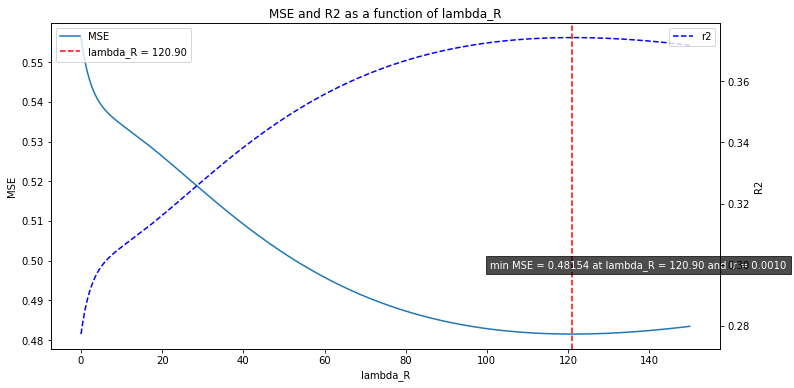

In [115]:
# let's pot the MSE and R2 as a function of lambda_R
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    rr_grad_desc_results_df["lambda"].values,
    rr_grad_desc_results_df["mse"].values,
    label="MSE",
)

# Add a vertical line at the minimum MSE
min_mse = rr_grad_desc_results_df["mse"].min()
min_mse_lambda = rr_grad_desc_results_df[rr_grad_desc_results_df["mse"] == min_mse]["lambda"].values[0]
min_mse_lr = rr_grad_desc_results_df[rr_grad_desc_results_df["mse"] == min_mse]["lr"].values[0]

ax.axvline(
    min_mse_lambda,
    color="red",
    linestyle="--",
    label=f"lambda_R = {min_mse_lambda:.2f}",
)
# Add text annotation for the minimum MSE with a black background and white text
ax.text(
    min_mse_lambda-20,
    rr_grad_desc_results_df["mse"].mean(),
    f"min MSE = {min_mse:.5f} at lambda_R = {min_mse_lambda:.2f} and lr = {min_mse_lr:.4f}",
    bbox=dict(facecolor="black", alpha=0.7),
    color="white",
)

# Create a twin Axes sharing the xaxis for the r2
ax2 = ax.twinx()
ax2.plot(
    rr_grad_desc_results_df["lambda"].values,
    rr_grad_desc_results_df["r2"].values,
    "b--",
    label="r2",
)
ax.set_xlabel("lambda_R")
ax.set_ylabel("MSE")
ax2.set_ylabel("R2")
ax.set_title("MSE and R2 as a function of lambda_R")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

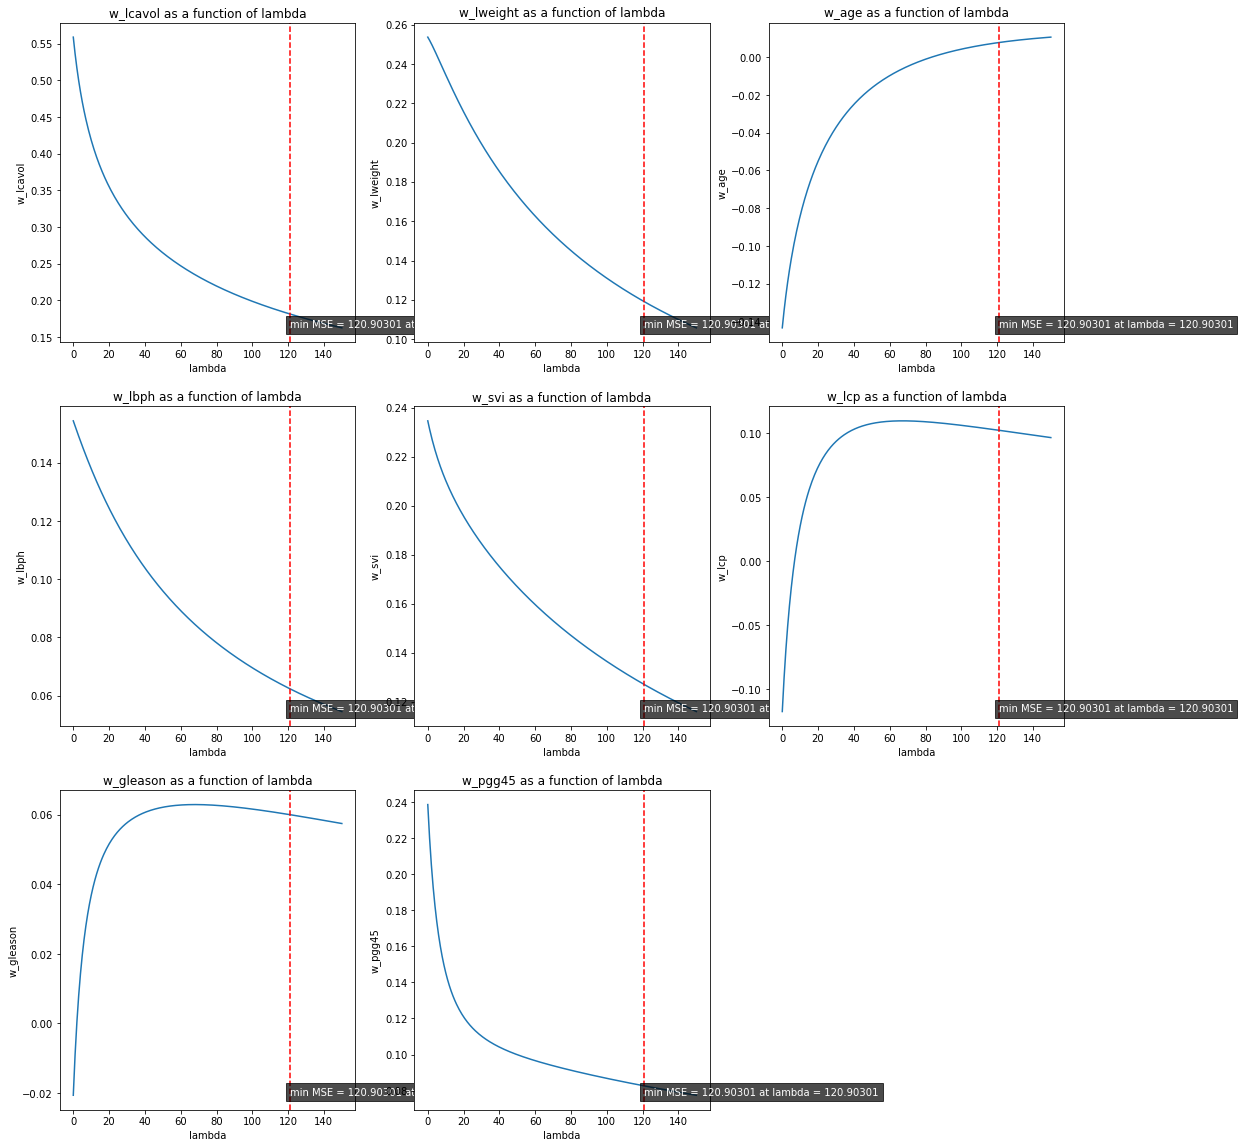

In [116]:
# Diplay a plot of the weights as a function of lambda_R
plot_weights_vs_model_param(rr_grad_desc_results_df, model_param="lambda")

In [117]:
rr_grad_desc_results_df_srt = rr_grad_desc_results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False)
rr_grad_desc_results_df_srt.head()

lambda     lr       mse      rmse        r2  w_lcavol  w_lweight  \
241  120.903010  0.001  0.481537  0.693929  0.374302  0.181423   0.119083   
242  121.404682  0.001  0.481537  0.693929  0.374301  0.181052   0.118824   
240  120.401338  0.001  0.481539  0.693930  0.374300  0.181795   0.119343   
243  121.906355  0.001  0.481539  0.693930  0.374300  0.180684   0.118566   
239  119.899666  0.001  0.481541  0.693932  0.374296  0.182169   0.119604   

        w_age    w_lbph     w_svi     w_lcp  w_gleason   w_pgg45          bias  
241  0.007769  0.062351  0.127072  0.102333   0.060043  0.082613  5.724533e-15  
242  0.007835  0.062197  0.126863  0.102235   0.060001  0.082518 -5.998188e-15  
240  0.007702  0.062507  0.127281  0.102430   0.060084  0.082708  6.194610e-15  
243  0.007900  0.062043  0.126654  0.102138   0.059959  0.082423 -5.908679e-15  
239  0.007634  0.062662  0.127492  0.102527   0.060126  0.082804 -5.860466e-15

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

Text(0.5, 1.0, 'Basic Least Squares Regression')

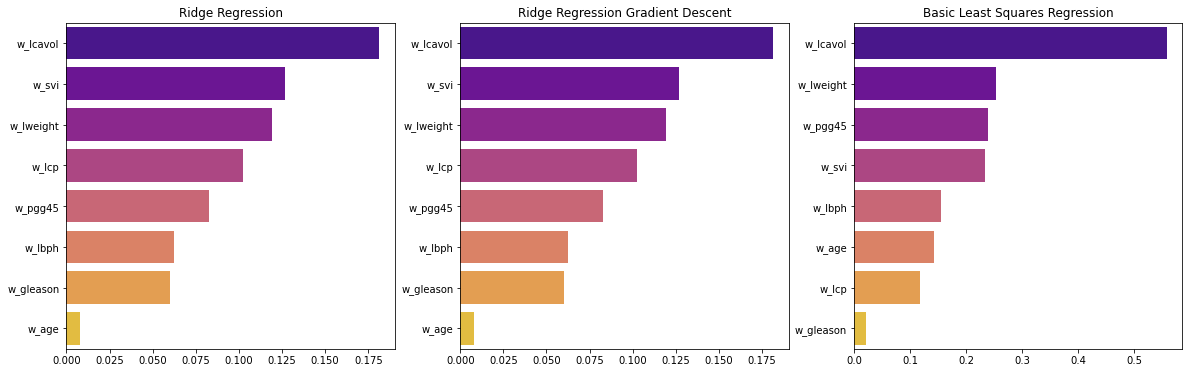

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# We will plot the coefficients in a descending order for both Ridge Regression, Ridge Regression Gradient Descent and LSR
# Plot the coefficients for Ridge Regression

rr_weights = rr_results_df_srt.iloc[0, 4:-1].abs().sort_values(ascending=False)

sns.barplot(
    y=rr_weights.index,
    x=rr_weights.values,
    ax=axes[0],
    palette="plasma",
)
axes[0].set_title("Ridge Regression")

rr_grad_desc_weights = rr_grad_desc_results_df_srt.iloc[0, 5:-1].abs().sort_values(ascending=False)

sns.barplot(
    y=rr_grad_desc_weights.index,
    x=rr_grad_desc_weights.values,
    ax=axes[1],
    palette="plasma",
)
axes[1].set_title("Ridge Regression Gradient Descent")

lsr_std_weights = pd.Series(np.abs(LSR_std._weights[:-1]), index=rr_results_df_srt.columns[4:-1]).sort_values(ascending=False)

sns.barplot(
    y=lsr_std_weights.index,
    x=lsr_std_weights.values,
    ax=axes[2],
    palette="plasma",
)
axes[2].set_title("Basic Least Squares Regression")

**Questions:**

**4.1** How many iterations are required to converge, and are there any performance differences compared to part 2?
I have tested a wide range of values for both $\lambda$ and the learning rate. The results are as follows:
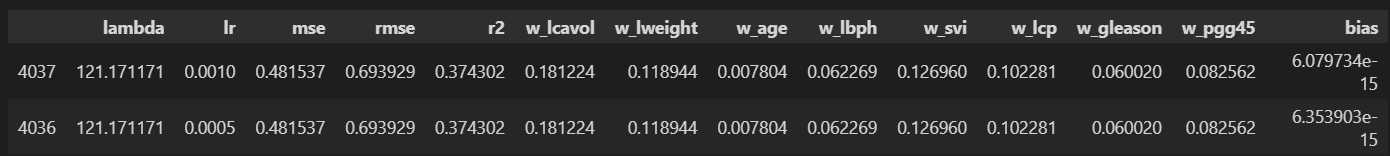

As can be seen from above, the MSEs are the same as that of the regular Ridge Regression model. This is expected since the gradient descent method is simply an iterative method of finding the optimal solution.

In all cases, the convergence took about 1500 iterations.

**4.2** Derive the gradient of L2 regularization loss. Encode your answer as [$\LaTeX$ equations](https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb), and justify every step, please.

The loss function $ L $ for Ridge Regression is given by:

$$
L(\mathbf{w}) = ||\mathbf{y} - \mathbf{Xw}||^2_2 + \lambda ||\mathbf{w}||^2_2
$$

Where:
- $ \mathbf{y} $ is the target vector.
- $ \mathbf{X} $ is the feature matrix.
- $ \mathbf{w} $ is the weight vector.
- $ \lambda $ is the regularization parameter.
- $ ||\cdot||_2 $ denotes the L2 norm.

We need to find the gradient of this loss function with respect to the weight vector $ \mathbf{w} $. To do this, we'll take the derivative of each term separately and then sum them up.

### Derivative of the First Term

The first term is the Mean Squared Error (MSE) loss:

$$
L_1(\mathbf{w}) = ||\mathbf{y} - \mathbf{Xw}||^2_2
$$

Taking the derivative with respect to \( \mathbf{w} \):

$$
\nabla_{\mathbf{w}} L_1 = -2\mathbf{X}^T(\mathbf{y} - \mathbf{Xw})
$$

### Derivative of the Second Term

The second term is the L2 regularization term:

$$
L_2(\mathbf{w}) = \lambda ||\mathbf{w}||^2_2
$$

Taking the derivative with respect to \( \mathbf{w} \):

$$
\nabla_{\mathbf{w}} L_2 = 2\lambda \mathbf{w}
$$

### Summing Them Up

Now, we sum up the two gradients to get the gradient of the total loss function:

$$
\nabla_{\mathbf{w}} L = \nabla_{\mathbf{w}} L_1 + \nabla_{\mathbf{w}} L_2
$$

$$
= -2\mathbf{X}^T(\mathbf{y} - \mathbf{Xw}) + 2\lambda \mathbf{w}
$$

And that's the gradient of the L2 regularization loss! This gradient is used in gradient descent optimization algorithms to update the weights $ \mathbf{w} $ during training in order to minimize the loss function $ L $.

**4.3** Do you converge on the same minimum loss value? How do the coefficients compare to part 1?

Yes, we do converge on the same minimum loss value as the original RidgeRegression implementation. Let's take a look at the coefficients of the two models side by side:

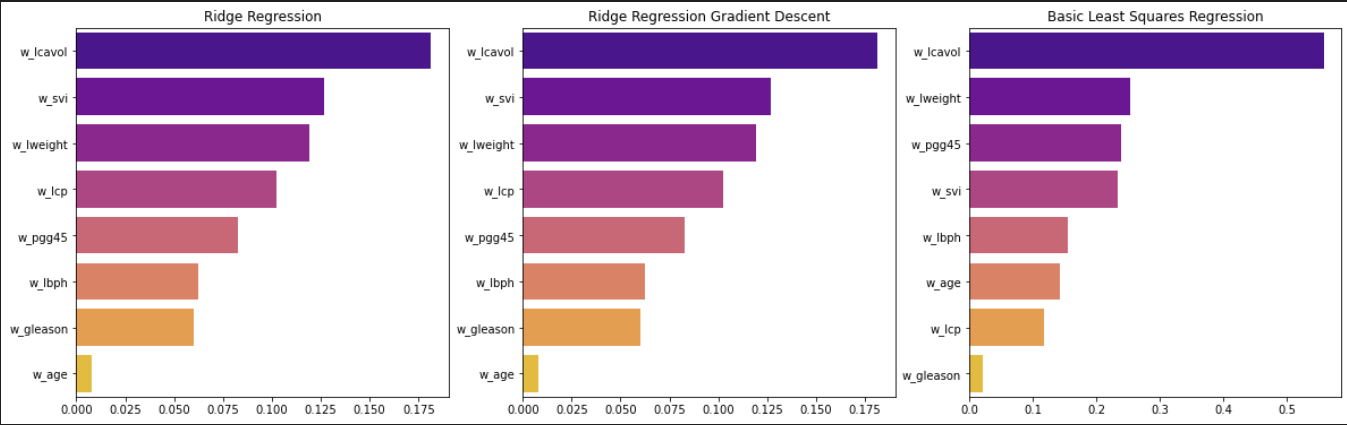

# 5. [OPTIONAL] Iterative Optimization using Coordinate Descent

**Worth up to 2% of the semester grade.**

Review Hastie 3.8.6 and this [presentation](https://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/coordinate_descent.pdf) on coordinate descent. Using just numpy reimplement part 3 with coordinate descent. Like part 3, iterate through the regression penalty term, $\lambda$, and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.



In [122]:
class LassoRegressionCD(BaseLearningAlgorithm):
    """A Lasso Regression model implemented using Coordinate Descent.
    Coordinate descent is an optimization algorithm that successively minimizes
    along coordinate directions to find the minimum of a function. The choice of
    which coordinate (or coefficient) to minimize along is done greedily."""
    
    def __init__(self, alpha: float, max_iter: int, tol: float):
        """Initializes the model."""
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        n, p = X_train.shape
        # Compute the least squares solution using eq. 3.52
        self._weights = np.zeros(p)
        
        # alpha_max = np.dot(X_train[:, :-1].T, y_train).abs().max() / n
        
        # if self.alpha >= alpha_max:
        #     print(f"alpha = {self.alpha} >= alpha_max = {alpha_max}. Setting alpha = {alpha_max}")
        #     self.alpha = alpha_max
        
        for i in range(self.max_iter):
            weights_cpy = self._weights.copy()
            for j in range(p-1):
                tmp_weights = self._weights.copy()
                # Purge the jth feature by setting its weight to 0
                tmp_weights[j] = 0
                # Compute the residual
                residuals = y_train - X_train @ tmp_weights
                # Compute the jth coordinate of the gradient
                coord = X_train[:, j] @ residuals
                
                # Compute the soft threshold
                if coord < -self.alpha:
                    self._weights[j] = coord + self.alpha
                elif coord > self.alpha:
                    self._weights[j] = coord - self.alpha
                else:
                    self._weights[j] = 0
                    
                # Include the variance of the jth feature in the loss
                # this is done to make the updated coefficient invariant to the scale of the feature
                self._weights[j] /= X_train[:, j].T @ X_train[:, j]
                
            # Terminate if the loss or the predictions contain NaNs
            if np.isnan(self._weights).any():
                print(f"NaNs encountered at iteration {i}.")
                break    
            
            # Check for convergence
            if np.sqrt(((self._weights - weights_cpy) ** 2).sum()) < self.tol:
                print(f"Converged after {i} iterations.")
                break
                        
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights
        
    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Lasso Regression Coordinate Descent"

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Converged after 39 iterations.
Mean Squared Error: 0.5519248164285006
Root Mean Squared Error: 0.7429164262745175
R^2: 0.28284179102212614


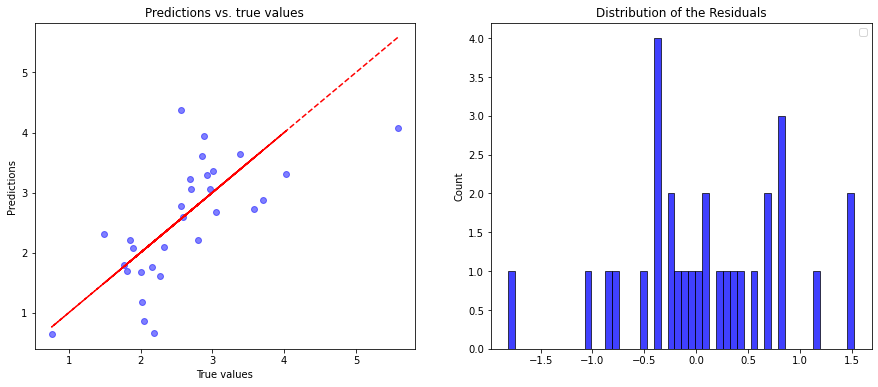

In [123]:
# Let's try alpha = 0.1, max_iter = 10000, tol = 1e-8
alpha = 0.1
max_iter = 10000
tol = 1e-8

std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_std, y_train_std = std_scaler.transform(X_train, y_train)
X_test_std = std_scaler.transform(X_test)

lasso_regression_cd_model = LassoRegressionCD(alpha=alpha, max_iter=max_iter, tol=tol)
lasso_regression_cd_model.train(X_train_std, y_train_std)
y_pred_lasso_cd = lasso_regression_cd_model.predict(X_test_std)
y_pred_lasso_cd = std_scaler.inverse_transform(y=y_pred_lasso_cd)
reg_res_lasso_cd = regression_report(y_test, y_pred_lasso_cd)

In [124]:
# Let's set a range of values for alpha
alpha_range = np.linspace(0, 150, 10000).tolist()
max_iter = 100000
tol = 1e-8

# Setting up a dataframe where we'll store the results and the weights
metrics_to_track = ['alpha', 'mse', 'rmse', 'r2'] + [f'w_{feature}' for feature in df_train.columns if feature != 'lpsa'] + ['bias']
num_iters_total = len(alpha_range)

lasso_cd_results = np.zeros((num_iters_total, len(metrics_to_track)))


for i, alpha in enumerate(alpha_range):
    print(f">>> Model {i}/{num_iters_total}. alpha: {alpha}")

    lasso_regression_cd_model = LassoRegressionCD(alpha=alpha, max_iter=max_iter, tol=tol)
    lasso_regression_cd_model.train(X_train_std, y_train_std)
    y_pred_lasso_cd = lasso_regression_cd_model.predict(X_test_std)
    
    # check if the predictions contain NaNs or inf
    if np.isnan(y_pred_lasso_cd).any() or np.isinf(y_pred_lasso_cd).any():
        print(f"[INFO] Weights have diverged") 
        print(f"[INFO] Skipping alpha = {alpha}.")
        lasso_cd_results[i] = [alpha] + [np.nan for _ in range(len(metrics_to_track)-1)]
        
        continue
        
    y_pred_lasso_cd = std_scaler.inverse_transform(y=y_pred_lasso_cd)
    
    lasso_cd_reg_results = regression_report(y_test, y_pred_lasso_cd, plot_results=False)
    lasso_cd_test_mse = lasso_cd_reg_results['MSE'][0]
    lasso_cd_test_rmse = lasso_cd_reg_results['RMSE'][0]
    lasso_cd_test_r2 = lasso_cd_reg_results['R^2'][0]
    
    weights = lasso_regression_cd_model._weights.tolist()
    # record the results   
    lasso_cd_results[i] = [alpha, lasso_cd_test_mse, lasso_cd_test_rmse, lasso_cd_test_r2] + weights

>>> Model 0/10000. alpha: 0.0
Converged after 41 iterations.
Mean Squared Error: 0.5561806403095327
Root Mean Squared Error: 0.7457751942170863
R^2: 0.27731187292205506
>>> Model 1/10000. alpha: 0.015001500150015001
Converged after 40 iterations.
Mean Squared Error: 0.5555157999798068
Root Mean Squared Error: 0.7453293231718492
R^2: 0.2781757509103794
>>> Model 2/10000. alpha: 0.030003000300030003
Converged after 40 iterations.
Mean Squared Error: 0.5548602795046218
Root Mean Squared Error: 0.744889441128428
R^2: 0.27902751889750144
>>> Model 3/10000. alpha: 0.045004500450045004
Converged after 40 iterations.
Mean Squared Error: 0.5542140787618571
Root Mean Squared Error: 0.744455558621102
R^2: 0.27986717704210184
>>> Model 4/10000. alpha: 0.060006000600060005
Converged after 40 iterations.
Mean Squared Error: 0.5535771977515129
Root Mean Squared Error: 0.7440276861458268
R^2: 0.2806947253441805
>>> Model 5/10000. alpha: 0.075007500750075
Converged after 40 iterations.
Mean Squared Err

In [128]:
# Let's sort the results by the MSE and R2
lasso_cd_results_df = pd.DataFrame(lasso_cd_results, columns=metrics_to_track)
lasso_cd_results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False).head(10)

alpha       mse      rmse        r2  w_lcavol  w_lweight  w_age  \
811  12.166217  0.390304  0.624743  0.492848  0.481668   0.120804    0.0   
810  12.151215  0.390305  0.624744  0.492847  0.481702   0.121006    0.0   
812  12.181218  0.390305  0.624744  0.492847  0.481634   0.120602    0.0   
809  12.136214  0.390305  0.624744  0.492847  0.481736   0.121207    0.0   
813  12.196220  0.390305  0.624744  0.492846  0.481600   0.120400    0.0   
808  12.121212  0.390306  0.624745  0.492845  0.481770   0.121409    0.0   
814  12.211221  0.390307  0.624745  0.492845  0.481566   0.120199    0.0   
807  12.106211  0.390307  0.624746  0.492844  0.481804   0.121611    0.0   
815  12.226223  0.390308  0.624746  0.492843  0.481532   0.119997    0.0   
806  12.091209  0.390309  0.624747  0.492841  0.481839   0.121813    0.0   

     w_lbph     w_svi  w_lcp  w_gleason   w_pgg45  bias  
811     0.0  0.096789    0.0        0.0  0.021538   0.0  
810     0.0  0.096889    0.0        0.0  0.021699   0.0  
812     0.0  0.096689    0.0        0.0  0.021378   0.0  
809     0.0  0.096989    0.0        0.0  0.021859   0.0  
813     0.0  0.096588    0.0        0.0  0.021218   0.0  
808     0.0  0.097090    0.0        0.0  0.022019   0.0  
814     0.0  0.096488    0.0        0.0  0.021057   0.0  
807     0.0  0.097190    0.0        0.0  0.022180   0.0  
815     0.0  0.096388    0.0        0.0  0.020897   0.0  
806     0.0  0.097290    0.0        0.0  0.022340   0.0

Text(-7.833783378337834, 0.7154412151388894, 'min MSE = 0.39030 at alpha = 12.17')

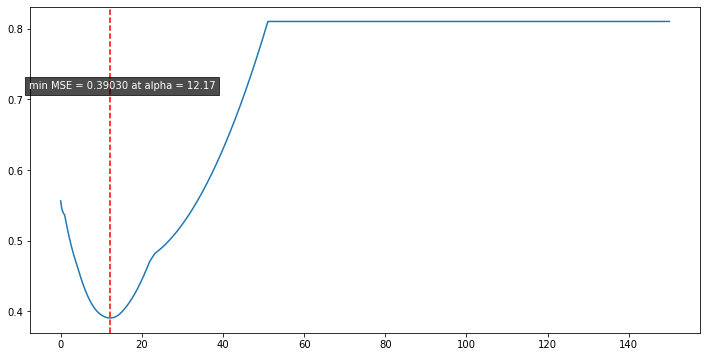

In [129]:
# let's pot the MSE and R2 as a function of alpha
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    lasso_cd_results_df["alpha"].values,
    lasso_cd_results_df["mse"].values,
    label="MSE",
)

# Add a vertical line at the minimum MSE
min_mse = lasso_cd_results_df["mse"].min()
min_mse_alpha = lasso_cd_results_df[lasso_cd_results_df["mse"] == min_mse]["alpha"].values[0]

ax.axvline(
    min_mse_alpha,
    color="red",
    linestyle="--",
    label=f"alpha = {min_mse_alpha:.2f}",
)
# Add text annotation for the minimum MSE with a black background and white text
ax.text(
    min_mse_alpha-20,
    lasso_cd_results_df["mse"].mean(),
    f"min MSE = {min_mse:.5f} at alpha = {min_mse_alpha:.2f}",
    bbox=dict(facecolor="black", alpha=0.7),
    color="white",
)


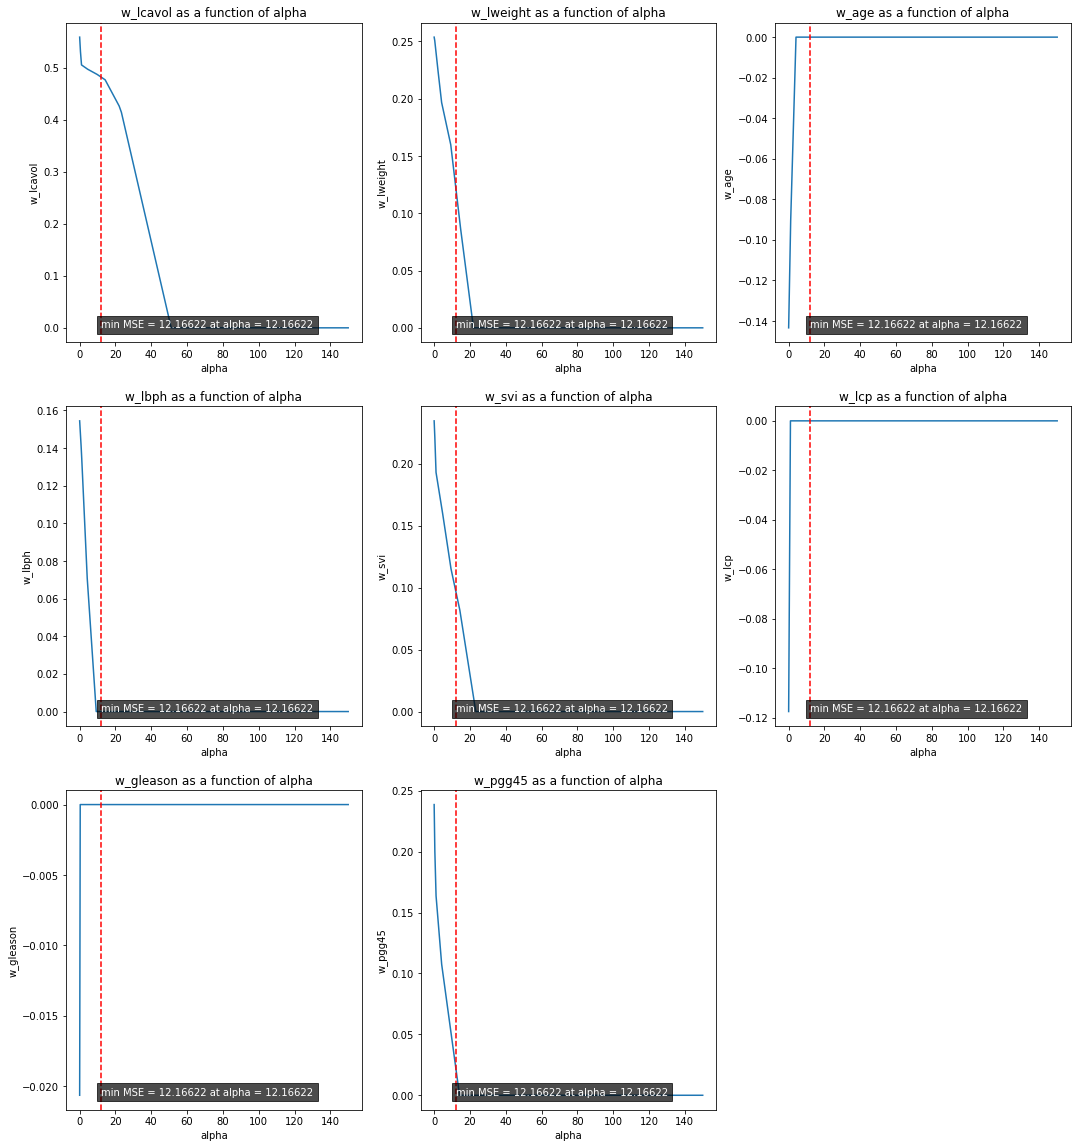

In [131]:
# Diplay a plot of the weights as a function of alpha
plot_weights_vs_model_param(lasso_cd_results_df, model_param="alpha")

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

Text(0.5, 1.0, 'Basic Least Squares Regression')

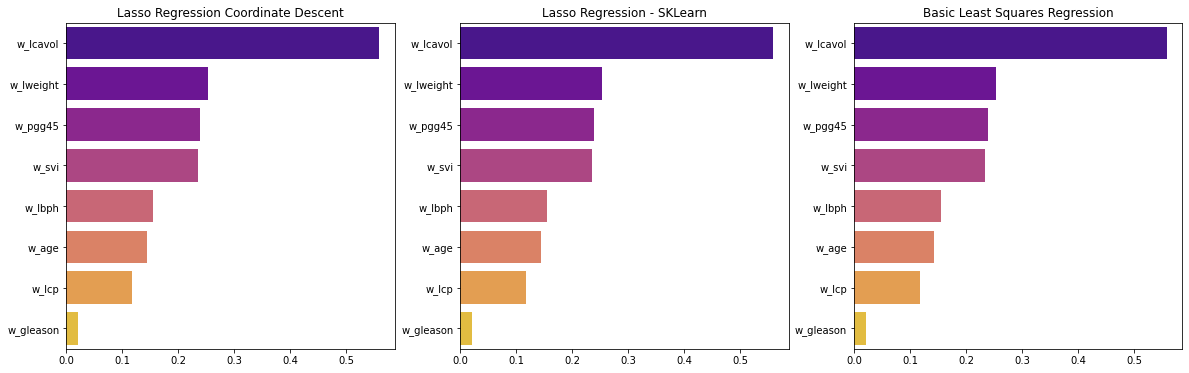

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# We will plot the coefficients in a descending order for both Lasso Regression Coordinate Descent, 
# Lasso Regression Gradient Descent and LSR
# Plot the coefficients for Ridge Regression

lr_weights = lr_results_df.iloc[0, 4:-1].abs().sort_values(ascending=False)

sns.barplot(
    y=lr_weights.index,
    x=lr_weights.values,
    ax=axes[0],
    palette="plasma",
)
axes[0].set_title("Lasso Regression Coordinate Descent")


lrcd_weights = lasso_cd_results_df.iloc[0, 4:-1].abs().sort_values(ascending=False)

sns.barplot(
    y=lrcd_weights.index,
    x=lrcd_weights.values,
    ax=axes[1],
    palette="plasma",
)
axes[1].set_title("Lasso Regression - SKLearn")


lsr_std_weights = pd.Series(np.abs(LSR_std._weights[:-1]), index=rr_results_df_srt.columns[4:-1]).sort_values(ascending=False)

sns.barplot(
    y=lsr_std_weights.index,
    x=lsr_std_weights.values,
    ax=axes[2],
    palette="plasma",
)
axes[2].set_title("Basic Least Squares Regression")

**Questions:**

**5.1** How does your implementation compare with Scikit-Learn’s implementation in terms of minimum MSE loss and coefficients?

The MSE Loss of my implemetion is very slightly higher than that of the Scikit-Learn implementation. The coefficients, however, are exactly the same. The results are displayed in the above graph.

**5.2** Is the optimization surface convex or non-convex?

For Lasso Regression, the optimization surface is non-convex. This is because the L1 regularization term is non-differentiable at 0. This means that the optimization surface will have "corners" at 0 and thus, the optimization surface will be non-convex.

**5.3** What makes the optimization surface *non-smooth* and how is coordinate descent able to overcome this problem?

The discontinuity of the L1 regularization term at 0 makes the optimization surface non-smooth. However, this regularization function is separable and thus, coordinate descent is able to overcome this problem by optimizing one coordinate, $w_j$ at a time. The workaround for the point of discontinuity is the soft thresholding function which is defined as follows:

$$ S_{\lambda}(a) = sign(a) (|a| - \lambda)_{+} $$

Where:
- $ a $ is the input value.
- $ \lambda $ is the regularization parameter.

Even though the Lasso objective function is non-smooth, coordinate descent converges to a global minimum under mild conditions. The algorithm iteratively reduces the objective function value and eventually stabilizes, finding a solution where the change in the objective function is below a predefined tolerance.